# Discovering the Kraichnan-Orszag system from data

### Main Article-
- https://readmedium.com/discovering-differential-equations-with-physics-informed-neural-networks-and-symbolic-regression-c28d279c0b4d

### Some more articles to read-
- https://readmedium.com/operator-learning-via-physics-informed-deeponet-lets-implement-it-from-scratch-6659f3179887
- https://i-systems.github.io/tutorial/KSME/CAE/220520/01_PINN.html
- https://docs.sciml.ai/NeuralPDE/stable/manual/ode/

### Objective

In this notebook, we investigate combining PINN with symbolic regression to discover ODE systems. Our target ODE system can be written as follows:

\begin{align}
    \frac{du_1}{dt} &= e^{-t/10}u_2u_3 \\
    \frac{du_2}{dt} &= u_1u_3 \\
    \frac{du_3}{dt} &= -2u_1u_2 \\
\end{align}

with an initial condition of $u_1(0)=1, u_2(0)=0.8, u_3(0)=0.5$.

For our case study, we assume that we only know the right-hand side of the third equation to be a linear transformation of $u_1u_2$, and have no knowledge of the first two equations. Essentially, we can rewrite the ODE system as follows:

\begin{align}
    \frac{du_1}{dt} &= f_1(t, u_1, u_2, u_3) \\
    \frac{du_2}{dt} &= f_2(t, u_1, u_2, u_3) \\
    \frac{du_3}{dt} &= au_1u_2 + b \\
\end{align}

where $a, b$ are unknown coefficients and $f_1, f_2$ are the unknown functions. By using PINN and symbolic regression, we aim to calibrate the values of $a$ and $b$, as well as the functional forms of $f_1$ and $f_2$.

### 0. Import libraries

In [1]:
# Common packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from scipy.integrate import solve_ivp
from collections import defaultdict
import time

import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

2023-12-29 05:38:50.149755: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### 1. Observational data generation

To begin with, we need to generate simulation data of the investigated ODE system, which will be used later for inverse calibration.

In [2]:
def simulate_ODEs(u_init, t_span, obs_num):
    """Simulate the ODE system and obtain observational data. 
    
    Args:
    ----
    u_init: list of initial condition for u1, u2, and u3
    t_span: lower and upper time limit for simulation
    obs_num: number of observational data points
    
    Outputs:
    --------
    u_obs: observed data for u's
    """
    
    # Define the target ODEs
    def odes(t, u):
        du1dt = np.exp(-t/10) * u[1] * u[2]
        du2dt = u[0] * u[2]
        du3dt = -2 * u[0] * u[1]
        return [du1dt, du2dt, du3dt]
    
    # Solve ODEs
    t_eval = np.linspace(t_span[0], t_span[1], obs_num)
    sol = solve_ivp(odes, t_span, u_init, method='RK45', t_eval=t_eval)
    
    # Restrcture obtained data
    u_obs = np.column_stack((sol.t, sol.y[0], sol.y[1], sol.y[2]))
    
    return u_obs

In [3]:
# Set up simulation
u_init = [1, 0.8, 0.5]
t_span = [0, 10]
obs_num = 1000

# Solve ODEs
u_obs = simulate_ODEs(u_init, t_span, obs_num)

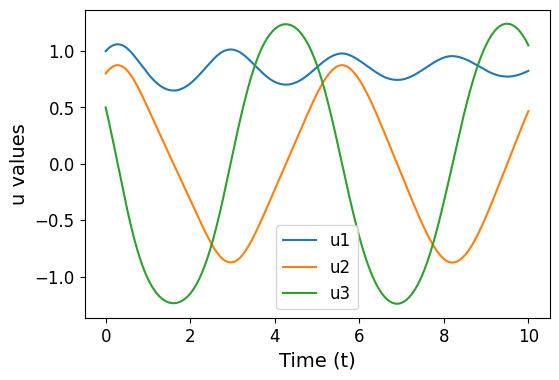

In [4]:
# Visualize the results
plt.figure(figsize=(6, 4))

plt.plot(u_obs[:, 0], u_obs[:, 1], label='u1')
plt.plot(u_obs[:, 0], u_obs[:, 2], label='u2')
plt.plot(u_obs[:, 0], u_obs[:, 3], label='u3')

plt.xlabel('Time (t)', fontsize=14)
plt.ylabel('u values', fontsize=14)
plt.tick_params(labelsize=12)
plt.legend(fontsize=12, frameon=True)

plt.savefig('u_profile.png', bbox_inches='tight', transparent=True)

### 2. Organize dataset

In [5]:
# Set batch size
data_batch_size = 100
ODE_batch_size = 1000

# Samples for enforcing data loss
X_train_data = tf.convert_to_tensor(u_obs[:, :1], dtype=tf.float32)
y_train_data = tf.convert_to_tensor(u_obs[:, 1:], dtype=tf.float32)
train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
train_ds_data = train_ds_data.shuffle(1000).batch(data_batch_size)

# Samples for enforcing ODE residual loss
N_collocation = 10000
X_train_ODE = tf.convert_to_tensor(np.linspace(0, 10, N_collocation).reshape(-1, 1), dtype=tf.float32)
train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size)

# Generate testing data
u_obs_test = simulate_ODEs(u_init, t_span, 5000)
X_test, y_test = u_obs_test[:, :1], u_obs_test[:, 1:]

### 3. Physics-informed Neural Networks

#### Define a custom layer for hosting unknown parameters

In [6]:
class ParameterLayer(tf.keras.layers.Layer):
    def __init__(self, a, b, trainable=True):
        super(ParameterLayer, self).__init__()
        self._a = tf.convert_to_tensor(a, dtype=tf.float32)
        self._b = tf.convert_to_tensor(b, dtype=tf.float32)
        self.trainable = trainable
        
    def build(self, input_shape):
        self.a = self.add_weight("a", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._a),
                                 trainable=self.trainable)
        self.b = self.add_weight("b", shape=(1,), 
                                 initializer=tf.keras.initializers.Constant(value=self._b),
                                 trainable=self.trainable)
        
    def get_config(self):
        return super().get_config()
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

#### Define Physics-informed Neural Network

In [7]:
def u_net(input_layer):
    """Definition of the network for u prediction."""
    
    hidden = input_layer
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(3)(hidden)
    return output


def f_net(input_layers, a_init=None, b_init=None):
    """Definition of the network for f prediction."""
    
    hidden = tf.keras.layers.Concatenate()(input_layers)
    for _ in range(2):
        hidden = tf.keras.layers.Dense(50, activation="tanh")(hidden)
    output = tf.keras.layers.Dense(2)(hidden)
    output = ParameterLayer(a_init, b_init)(output)
    return output


def create_PINN(a_init=None, b_init=None, verbose=False):
    """Definition of a physics-informed neural network.
    
    Args:
    ----
    a_init: initial value for parameter a
    b_init: initial value for parameter b
    verbose: boolean, indicate whether to show the model summary
    
    Outputs:
    --------
    model: the PINN model
    """
    # Input
    t_input = tf.keras.Input(shape=(1,), name="time")
    
    # u-NN
    u = u_net(t_input)
    
    # f-NN
    f = f_net([t_input, u], a_init, b_init)

    # PINN model
    model = tf.keras.models.Model(inputs=t_input, outputs=[u, f])
    
    if verbose:
        model.summary()
        
    return model

#### ODE loss

In [8]:
@tf.function
def ODE_residual_calculator(t, model):
    """ODE residual calculation.
    
    Args:
    ----
    t: temporal coordinate
    model: PINN model
    
    Outputs:
    --------
    ODE_residual: residual of the governing ODE
    """
    
    # Retrieve parameters
    a = model.layers[-1].a
    b = model.layers[-1].b
    
    with tf.GradientTape() as tape:
        tape.watch(t)
        u, f = model(t)
    
    # Calculate gradients
    dudt = tape.batch_jacobian(u, t)[:, :, 0]
    du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]
    
    # Compute residuals
    res1 = du1_dt - f[:, :1]
    res2 = du2_dt - f[:, 1:]
    res3 = du3_dt - (a*u[:, :1]*u[:, 1:2] + b)
    ODE_residual = tf.concat([res1, res2, res3], axis=1)
    
    return ODE_residual

#### Gradient descent step

In [9]:
@tf.function
def train_step(X_ODE, X, y, IC_weight, ODE_weight, data_weight, model):
    """Calculate gradients of the total loss with respect to network model parameters.
    
    Args:
    ----
    X_ODE: Collocation points for evaluating ODE residuals
    X: observed samples
    y: target values of the observed samples
    IC_weight: weight for initial condition loss
    ODE_weight: weight for ODE loss
    data_weight: weight for data loss
    model: PINN model
    
    Outputs:
    --------
    ODE_loss: calculated ODE loss
    IC_loss: calculated initial condition loss
    data_loss: calculated data loss
    total_loss: weighted sum of ODE loss, initial condition loss, and data loss
    gradients: gradients of the total loss with respect to network model parameters.
    """
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_weights)

        # Initial condition prediction
        y_pred_IC, _ = model(tf.zeros((1, 1)))

        # Equation residual
        ODE_residual = ODE_residual_calculator(t=X_ODE, model=model)
        
        # Data loss
        y_pred_data, _ = model(X)

        # Calculate loss
        IC_loss = tf.reduce_mean(keras.losses.mean_squared_error(tf.constant([[1.0, 0.8, 0.5]]), y_pred_IC))
        ODE_loss = tf.reduce_mean(tf.square(ODE_residual))
        data_loss = tf.reduce_mean(keras.losses.mean_squared_error(y, y_pred_data))
        
        # Weight loss
        total_loss = IC_loss*IC_weight + ODE_loss*ODE_weight + data_loss*data_weight

    gradients = tape.gradient(total_loss, model.trainable_variables)

    return ODE_loss, IC_loss, data_loss, total_loss, gradients

#### Define loss tracking class

In [10]:
class LossTracking:

    def __init__(self):
        self.mean_total_loss = keras.metrics.Mean()
        self.mean_IC_loss = keras.metrics.Mean()
        self.mean_ODE_loss = keras.metrics.Mean()
        self.mean_data_loss = keras.metrics.Mean()
        self.loss_history = defaultdict(list)

    def update(self, total_loss, IC_loss, ODE_loss, data_loss):
        self.mean_total_loss(total_loss)
        self.mean_IC_loss(IC_loss)
        self.mean_ODE_loss(ODE_loss)
        self.mean_data_loss(data_loss)

    def reset(self):
        self.mean_total_loss.reset_states()
        self.mean_IC_loss.reset_states()
        self.mean_ODE_loss.reset_states()
        self.mean_data_loss.reset_states()

    def print(self):
        print(f"IC={self.mean_IC_loss.result().numpy():.4e}, \
              ODE={self.mean_ODE_loss.result().numpy():.4e}, \
              data={self.mean_data_loss.result().numpy():.4e}, \
              total_loss={self.mean_total_loss.result().numpy():.4e}")
        
    def history(self):
        self.loss_history['total_loss'].append(self.mean_total_loss.result().numpy())
        self.loss_history['IC_loss'].append(self.mean_IC_loss.result().numpy())
        self.loss_history['ODE_loss'].append(self.mean_ODE_loss.result().numpy())
        self.loss_history['Data_loss'].append(self.mean_data_loss.result().numpy())

#### Define callback

In [11]:
class PrintParameters(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\na: {self.model.layers[-1].a.numpy()}, b: {self.model.layers[-1].b.numpy()}")

#### Training

In [13]:
# Set up training configurations
n_epochs = 1000
IC_weight= tf.constant(1.0, dtype=tf.float32)   
ODE_weight= tf.constant(1.0, dtype=tf.float32)
data_weight= tf.constant(1.0, dtype=tf.float32)
loss_tracker = LossTracking()
val_loss_hist = []
a_list, b_list = [], []

# Initial value for unknown parameters
a_init, b_init = -1, 1

# Set up optimizer
optimizer = keras.optimizers.Adam(learning_rate=2e-2)

with tf.device("GPU:0"):
    
    # Instantiate the PINN model
    PINN = create_PINN(a_init=a_init, b_init=b_init)
    PINN.compile(optimizer=optimizer)

    # Configure callbacks
    _callbacks = [keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=100),
                 tf.keras.callbacks.ModelCheckpoint('PINN_model.h5', monitor='val_loss', save_best_only=True),
                 PrintParameters()]
    callbacks = tf.keras.callbacks.CallbackList(
                    _callbacks, add_history=False, model=PINN)
    
    # Start training process
    for epoch in range(1, n_epochs + 1):  
        print(f"Epoch {epoch}:")

        for (X_ODE), (X, y) in zip(train_ds_ODE, train_ds_data):

            # Calculate gradients
            ODE_loss, IC_loss, data_loss, total_loss, gradients = train_step(X_ODE, X, y, IC_weight, 
                                                                             ODE_weight, data_weight, PINN)
            # Gradient descent
            PINN.optimizer.apply_gradients(zip(gradients, PINN.trainable_variables))

            # Loss tracking
            loss_tracker.update(total_loss, IC_loss, ODE_loss, data_loss)

        # Loss summary
        loss_tracker.history()
        loss_tracker.print()
        loss_tracker.reset()
        
        # Parameter recording
        a_list.append(PINN.layers[-1].a.numpy())
        b_list.append(PINN.layers[-1].b.numpy())

        ####### Validation
        val_res = ODE_residual_calculator(tf.reshape(tf.linspace(0.0, 10.0, 1000), [-1, 1]), PINN)
        val_ODE = tf.cast(tf.reduce_mean(tf.square(val_res)), tf.float32)

        u_init=tf.constant([[1.0, 0.8, 0.5]])
        val_pred_init, _ = PINN.predict(tf.zeros((1, 1)))
        val_IC = tf.reduce_mean(tf.square(val_pred_init - u_init))
        print(f"val_IC: {val_IC.numpy():.4e}, val_ODE: {val_ODE.numpy():.4e}, lr: {PINN.optimizer.lr.numpy():.2e}")

        # Callback at the end of epoch
        callbacks.on_epoch_end(epoch, logs={'val_loss': val_IC+val_ODE})
        val_loss_hist.append(val_IC+val_ODE)

        # Test dataset
        pred_test, _ = PINN.predict(X_test, batch_size=12800)
        print(f"RMSE: {mean_squared_error(y_test.flatten(), pred_test.flatten(), squared=False)}")
        
        
        # Re-shuffle dataset
        train_ds_data = tf.data.Dataset.from_tensor_slices((X_train_data, y_train_data))
        train_ds_data = train_ds_data.shuffle(10000).batch(data_batch_size) 
        
        train_ds_ODE = tf.data.Dataset.from_tensor_slices((X_train_ODE))
        train_ds_ODE = train_ds_ODE.shuffle(10*N_collocation).batch(ODE_batch_size) 

Epoch 1:
IC=3.8940e-01,               ODE=3.1953e+00,               data=2.2616e+00,               total_loss=5.8462e+00
1/1 [==============================] - 0s 52ms/step
val_IC: 2.2898e-01, val_ODE: 1.6458e-01, lr: 2.00e-02

a: [-0.9262363], b: [0.9870596]
1/1 [==============================] - 0s 10ms/step
RMSE: 1.3399819223597262
Epoch 2:
IC=1.0300e-01,               ODE=4.4298e-01,               data=9.2750e-01,               total_loss=1.4735e+00
1/1 [==============================] - 0s 10ms/step
val_IC: 5.2796e-02, val_ODE: 3.2808e-01, lr: 2.00e-02


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-0.8896165], b: [0.95791453]
1/1 [==============================] - 0s 14ms/step
RMSE: 0.6725457672047597
Epoch 3:
IC=2.9604e-02,               ODE=1.3242e-01,               data=5.4763e-01,               total_loss=7.0965e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.8992e-03, val_ODE: 2.8697e-02, lr: 2.00e-02

a: [-0.8763736], b: [0.88720596]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.7695494873646581
Epoch 4:
IC=8.5288e-03,               ODE=7.3419e-02,               data=5.1019e-01,               total_loss=5.9214e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 1.2776e-02, val_ODE: 1.1785e-01, lr: 2.00e-02

a: [-0.8736855], b: [0.82869285]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 13ms/step
RMSE: 0.632102857043762
Epoch 5:
IC=7.4439e-03,               ODE=1.0783e-01,               data=4.0076e-01,               total_loss=5.1604e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 6.4527e-03, val_ODE: 8.1110e-02, lr: 2.00e-02

a: [-0.8751957], b: [0.75453645]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.6358846074714571
Epoch 6:
IC=6.9058e-03,               ODE=8.1053e-02,               data=3.9156e-01,               total_loss=4.7952e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 6.2517e-03, val_ODE: 6.1032e-02, lr: 2.00e-02

a: [-0.8783094], b: [0.6754723]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.6301983977501402
Epoch 7:
IC=4.5215e-03,               ODE=6.3321e-02,               data=3.8085e-01,               total_loss=4.4870e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 4.4473e-03, val_ODE: 6.1561e-02, lr: 2.00e-02

a: [-0.88191843], b: [

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
val_IC: 4.5375e-04, val_ODE: 3.0195e-02, lr: 2.00e-02

a: [-0.8960814], b: [0.2694688]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.5790327207953343
Epoch 13:
IC=2.0643e-03,               ODE=2.1650e-02,               data=3.3121e-01,               total_loss=3.5492e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 8.1922e-04, val_ODE: 2.3058e-02, lr: 2.00e-02

a: [-0.8980647], b: [0.22030705]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.5660508299916189
Epoch 14:
IC=2.2932e-03,               ODE=1.6942e-02,               data=3.2171e-01,               total_loss=3.4095e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 8.6268e-04, val_ODE: 1.7753e-02, lr: 2.00e-02


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-0.89992], b: [0.1783301]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.5617691072599821
Epoch 15:
IC=2.2593e-03,               ODE=1.5062e-02,               data=3.1488e-01,               total_loss=3.3220e-01
1/1 [==============================] - 0s 11ms/step
val_IC: 4.8503e-04, val_ODE: 1.1708e-02, lr: 2.00e-02

a: [-0.9016319], b: [0.13961819]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.5619482172930931
Epoch 16:
IC=1.8227e-03,               ODE=1.1103e-02,               data=3.1557e-01,               total_loss=3.2849e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 6.6444e-04, val_ODE: 1.2702e-02, lr: 2.00e-02

a: [-0.90325594], b: [0.10899524]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step
RMSE: 0.558588214717285
Epoch 17:
IC=1.8219e-03,               ODE=1.3681e-02,               data=3.1313e-01,               total_loss=3.2863e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0896e-03, val_ODE: 1.3226e-02, lr: 2.00e-02

a: [-0.9048001], b: [0.08100635]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.5598530478238446
Epoch 18:
IC=1.6791e-03,               ODE=1.1358e-02,               data=3.0906e-01,               total_loss=3.2210e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 4.2334e-03, val_ODE: 1.1262e-02, lr: 2.00e-02

a: [-0.90641624], b: [0.06007541]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.5558193188413927
Epoch 19:
IC=2.6877e-03,               ODE=1.1599e-02,               data=3.1370e-01,               total_loss=3.2799e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 1.7883e-04, val_ODE: 1.3935e-02, lr: 2.00e-02

a: [-0.9079928],

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.54225561686513
Epoch 24:
IC=1.5984e-03,               ODE=1.0183e-02,               data=2.9575e-01,               total_loss=3.0753e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 2.2195e-04, val_ODE: 9.1927e-03, lr: 2.00e-02

a: [-0.9168185], b: [-0.00633659]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.5383890318271276
Epoch 25:
IC=1.0918e-03,               ODE=9.7563e-03,               data=2.8960e-01,               total_loss=3.0045e-01
1/1 [==============================] - 0s 12ms/step
val_IC: 3.8910e-03, val_ODE: 9.7101e-03, lr: 2.00e-02

a: [-0.9187677], b: [-0.00983642]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.5340912136035094
Epoch 26:
IC=9.7833e-04,               ODE=1.1876e-02,               data=2.8695e-01,               total_loss=2.9980e-01
1/1 [==============================] - 0s 9ms/step
val_IC: 6.1516e-04, val_ODE: 1.3098e-02, lr: 2.00e-02

a: [-0.92079836], b: [-0.01347875]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.5344308811374424
Epoch 27:
IC=1.5027e-03,               ODE=1.3140e-02,               data=2.8548e-01,               total_loss=3.0012e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 6.1477e-03, val_ODE: 1.4754e-02, lr: 2.00e-02

a: [-0.9229282], b: [-0.01532627]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.5380045047865365
Epoch 28:
IC=3.6008e-03,               ODE=1.2402e-02,               data=2.8045e-01,               total_loss=2.9645e-01
1/1 [==============================] - 0s 10ms/step
val_IC: 8.0837e-04, val_ODE: 1.0264e-02, lr: 2.00e-02

a: [-0.9250787

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.289668], b: [0.07124961]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.18963827516415016
Epoch 87:
IC=2.5281e-04,               ODE=7.1553e-03,               data=3.6677e-02,               total_loss=4.4086e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 1.3481e-04, val_ODE: 6.2045e-03, lr: 2.00e-02

a: [-1.297553], b: [0.07119406]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.18528242092771124
Epoch 88:
IC=2.7650e-04,               ODE=7.1602e-03,               data=3.5727e-02,               total_loss=4.3164e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 1.5728e-04, val_ODE: 4.6906e-03, lr: 2.00e-02

a: [-1.3054987], b: [0.0706308]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.18486737531260805
Epoch 89:
IC=3.3585e-04,               ODE=5.9411e-03,               data=3.3343e-02,               total_loss=3.9620e-02
1/1 [==============================] - 0s 11ms/step
val_IC: 1.4419e-04, val_ODE: 5.1094e-

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.1806340662184213
Epoch 90:
IC=3.2083e-04,               ODE=6.2137e-03,               data=3.2705e-02,               total_loss=3.9239e-02
1/1 [==============================] - 0s 9ms/step
val_IC: 5.2391e-05, val_ODE: 6.0959e-03, lr: 2.00e-02

a: [-1.3210588], b: [0.07104395]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.1769041039729892
Epoch 91:
IC=2.2175e-04,               ODE=5.6598e-03,               data=3.1853e-02,               total_loss=3.7734e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.2758e-05, val_ODE: 5.3516e-03, lr: 2.00e-02

a: [-1.3288373], b: [0.070932]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.17467268269451236
Epoch 92:
IC=3.3827e-04,               ODE=5.5897e-03,               data=2.9929e-02,               total_loss=3.5857e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 2.0318e-04, val_ODE: 5.3295e-03, lr: 2.00e-02

a: [-1.3364435], b

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.1630441776253205
Epoch 95:
IC=2.1017e-04,               ODE=4.9505e-03,               data=2.7157e-02,               total_loss=3.2317e-02
1/1 [==============================] - 0s 9ms/step
val_IC: 2.0174e-04, val_ODE: 4.3974e-03, lr: 2.00e-02

a: [-1.3587886], b: [0.06872857]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.1633951767998257
Epoch 96:
IC=2.8287e-04,               ODE=4.8487e-03,               data=2.6796e-02,               total_loss=3.1927e-02
1/1 [==============================] - 0s 11ms/step
val_IC: 1.9278e-04, val_ODE: 3.9308e-03, lr: 2.00e-02

a: [-1.3661083], b: [0.0679052]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.15917702921532242
Epoch 97:
IC=2.7452e-04,               ODE=5.2262e-03,               data=2.6668e-02,               total_loss=3.2169e-02
1/1 [==============================] - 0s 9ms/step
val_IC: 1.5557e-04, val_ODE: 5.9035e-03, lr: 2.00e-02

a: [-1.3732487], b

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.441277], b: [0.05994146]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.13476919432825463
Epoch 108:
IC=1.9523e-04,               ODE=3.6941e-03,               data=1.8813e-02,               total_loss=2.2702e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.3611e-04, val_ODE: 3.3899e-03, lr: 2.00e-02

a: [-1.447706], b: [0.06052498]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.14878361084687597
Epoch 109:
IC=3.1244e-04,               ODE=4.9495e-03,               data=1.9639e-02,               total_loss=2.4901e-02
1/1 [==============================] - 0s 11ms/step
val_IC: 3.5770e-04, val_ODE: 5.2411e-03, lr: 2.00e-02

a: [-1.4540429], b: [0.05917156]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.13959902817991252
Epoch 110:
IC=2.7689e-04,               ODE=4.1729e-03,               data=1.7910e-02,               total_loss=2.2360e-02
1/1 [==============================] - 0s 11ms/step
val_IC: 2.9068e-04, val_ODE: 2.37

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.12613255140358257
Epoch 112:
IC=2.8958e-04,               ODE=2.9038e-03,               data=1.6232e-02,               total_loss=1.9426e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 4.3836e-04, val_ODE: 3.6625e-03, lr: 2.00e-02

a: [-1.4727141], b: [0.05883401]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.12094142236421067
Epoch 113:
IC=2.7054e-04,               ODE=3.7551e-03,               data=1.7032e-02,               total_loss=2.1057e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 7.2503e-04, val_ODE: 4.0388e-03, lr: 2.00e-02

a: [-1.4788332], b: [0.05978698]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.13550655916761914
Epoch 114:
IC=3.8253e-04,               ODE=5.3313e-03,               data=1.9213e-02,               total_loss=2.4927e-02
1/1 [==============================] - 0s 9ms/step
val_IC: 2.8881e-04, val_ODE: 2.5229e-03, lr: 2.00e-02

a: [-1.4848

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.4966983], b: [0.05879279]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.12294713711830442
Epoch 117:
IC=1.6162e-04,               ODE=2.9592e-03,               data=1.4452e-02,               total_loss=1.7573e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 5.6112e-04, val_ODE: 2.6319e-03, lr: 2.00e-02

a: [-1.5024719], b: [0.05812906]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.11981640823509747
Epoch 118:
IC=4.7717e-04,               ODE=2.8422e-03,               data=1.4130e-02,               total_loss=1.7449e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 1.5927e-05, val_ODE: 2.9528e-03, lr: 2.00e-02

a: [-1.5082166], b: [0.05732111]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.11162744282750652
Epoch 119:
IC=2.0178e-04,               ODE=2.5291e-03,               data=1.3458e-02,               total_loss=1.6189e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 2.6834e-04, val_ODE: 4.

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.09701404756956647
Epoch 129:
IC=2.3558e-04,               ODE=2.3983e-03,               data=1.0376e-02,               total_loss=1.3010e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 2.8522e-04, val_ODE: 3.5957e-03, lr: 2.00e-02

a: [-1.5670979], b: [0.05575551]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.09871950042575021
Epoch 130:
IC=2.1134e-04,               ODE=2.2470e-03,               data=9.8415e-03,               total_loss=1.2300e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 5.1417e-05, val_ODE: 1.8052e-03, lr: 2.00e-02

a: [-1.57203], b: [0.05503384]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.09582743968243508
Epoch 131:
IC=1.1301e-04,               ODE=1.6853e-03,               data=9.2336e-03,               total_loss=1.1032e-02
1/1 [==============================] - 0s 10ms/step
val_IC: 3.2549e-04, val_ODE: 1.6529e-03, lr: 2.00e-02

a: [-1.57699

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.08908471233797474
Epoch 137:
IC=1.5069e-04,               ODE=1.4075e-03,               data=7.9485e-03,               total_loss=9.5066e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 3.3068e-04, val_ODE: 7.4742e-04, lr: 2.00e-02

a: [-1.6055022], b: [0.05200549]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.09089486385185898
Epoch 138:
IC=1.9870e-04,               ODE=1.6039e-03,               data=7.8203e-03,               total_loss=9.6229e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 4.6917e-05, val_ODE: 1.5105e-03, lr: 2.00e-02

a: [-1.6099916], b: [0.05173451]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.08619589362466701
Epoch 139:
IC=1.6755e-04,               ODE=1.6848e-03,               data=7.5625e-03,               total_loss=9.4148e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1999e-04, val_ODE: 1.2242e-03, lr: 2.00e-02

a: [-1.6144723], b: [0.05133948]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.08551030155352159
Epoch 140:
IC=7.3413e-05,               ODE=1.6178e-03,               data=7.4016e-03,               total_loss=9.0928e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 4.4967e-05, val_ODE: 1.2332e-03, lr: 2.00e-02

a: [-1.6188896], b: [0.05208456]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.08992187291408696
Epoch 141:
IC=2.4770e-04,               ODE=1.5433e-03,               data=7.4248e-03,               total_loss=9.2159e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0439e-04, val_ODE: 1.6690e-03, lr: 2.00e-02

a: [-1.623

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.07983646017636155
Epoch 147:
IC=1.1149e-04,               ODE=1.3398e-03,               data=6.0728e-03,               total_loss=7.5241e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 3.7366e-05, val_ODE: 1.6493e-03, lr: 2.00e-02

a: [-1.6486311], b: [0.04841698]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.07800316672776521
Epoch 148:
IC=2.1917e-04,               ODE=1.5169e-03,               data=5.9366e-03,               total_loss=7.6726e-03
1/1 [==============================] - 0s 14ms/step
val_IC: 4.2245e-04, val_ODE: 6.7041e-04, lr: 2.00e-02

a: [-1.652648], b: [0.0481954]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.0764036430972946
Epoch 149:
IC=1.2646e-04,               ODE=1.2386e-03,               data=5.6662e-03,               total_loss=7.0313e-03
1/1 [==============================] - 0s 9ms/step
val_IC: 1.9108e-05, val_ODE: 1.4178e-03, lr: 2.00e-02

a: [-1.6566272

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.0651003602558801
Epoch 161:
IC=1.9700e-04,               ODE=1.5031e-03,               data=4.2283e-03,               total_loss=5.9284e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.4880e-04, val_ODE: 1.5476e-03, lr: 2.00e-02

a: [-1.7009993], b: [0.04204215]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.06809618580321872
Epoch 162:
IC=1.3723e-04,               ODE=1.2103e-03,               data=4.1683e-03,               total_loss=5.5158e-03
1/1 [==============================] - 0s 9ms/step
val_IC: 4.6808e-05, val_ODE: 1.3293e-03, lr: 2.00e-02

a: [-1.7043931], b: [0.04110855]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.058486439566755616
Epoch 163:
IC=5.1919e-05,               ODE=1.1122e-03,               data=3.7757e-03,               total_loss=4.9398e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 9.9124e-06, val_ODE: 1.3841e-03, lr: 2.00e-02

a: [-1.7078

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.05942807138831753
Epoch 168:
IC=7.1342e-05,               ODE=9.9942e-04,               data=3.2528e-03,               total_loss=4.3236e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 3.2933e-05, val_ODE: 8.5247e-04, lr: 2.00e-02

a: [-1.7241745], b: [0.03834653]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.05439489178188569
Epoch 169:
IC=4.7482e-05,               ODE=8.5657e-04,               data=3.0916e-03,               total_loss=3.9956e-03
1/1 [==============================] - 0s 9ms/step
val_IC: 4.0835e-05, val_ODE: 9.5809e-04, lr: 2.00e-02

a: [-1.727303], b: [0.03793057]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.05262406784435368
Epoch 170:
IC=4.5104e-05,               ODE=8.2691e-04,               data=2.9745e-03,               total_loss=3.8465e-03
1/1 [==============================] - 0s 9ms/step
val_IC: 3.4096e-05, val_ODE: 1.1523e-03, lr: 2.00e-02

a: [-1.730459

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.048342907084430724
Epoch 178:
IC=4.3460e-05,               ODE=8.6689e-04,               data=2.4216e-03,               total_loss=3.3320e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 5.0567e-05, val_ODE: 1.1590e-03, lr: 2.00e-02

a: [-1.7539464], b: [0.03263596]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.048713988590620885
Epoch 179:
IC=7.7887e-05,               ODE=7.9975e-04,               data=2.2705e-03,               total_loss=3.1481e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 7.3876e-05, val_ODE: 7.0777e-04, lr: 2.00e-02

a: [-1.756712], b: [0.03175645]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.04586409941623072
Epoch 180:
IC=3.8621e-05,               ODE=6.8086e-04,               data=2.1202e-03,               total_loss=2.8396e-03
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4558e-05, val_ODE: 7.0090e-04, lr: 2.00e-02

a: [-1.759

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.04508937145394109
Epoch 181:
IC=3.0224e-05,               ODE=7.2099e-04,               data=2.1905e-03,               total_loss=2.9417e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 1.9398e-05, val_ODE: 7.3548e-04, lr: 2.00e-02

a: [-1.7622403], b: [0.03086994]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.04686713557263479
Epoch 182:
IC=3.8417e-05,               ODE=7.3083e-04,               data=2.0663e-03,               total_loss=2.8356e-03
1/1 [==============================] - 0s 9ms/step
val_IC: 1.7922e-05, val_ODE: 1.0679e-03, lr: 2.00e-02

a: [-1.76495], b: [0.03075629]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.04310544152961723
Epoch 183:
IC=3.2909e-05,               ODE=8.0710e-04,               data=2.0490e-03,               total_loss=2.8890e-03
1/1 [==============================] - 0s 9ms/step
val_IC: 6.5206e-05, val_ODE: 6.8821e-04, lr: 2.00e-02

a: [-1.7676319]

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.04252615696113162
Epoch 193:
IC=6.8183e-05,               ODE=9.2320e-04,               data=1.8325e-03,               total_loss=2.8239e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 8.9421e-05, val_ODE: 1.5244e-03, lr: 2.00e-02

a: [-1.7927642], b: [0.02587436]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.034573105693319534
Epoch 194:
IC=7.0877e-05,               ODE=8.9523e-04,               data=1.5483e-03,               total_loss=2.5144e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.9129e-05, val_ODE: 1.1137e-03, lr: 2.00e-02

a: [-1.795176], b: [0.02549518]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.038735054990423026
Epoch 195:
IC=4.1422e-05,               ODE=7.6569e-04,               data=1.4606e-03,               total_loss=2.2677e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 6.1762e-05, val_ODE: 5.2048e-04, lr: 2.00e-02

a: [-1.79

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.79983], b: [0.02469016]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.03648405192339777
Epoch 197:
IC=4.4327e-05,               ODE=6.2779e-04,               data=1.3973e-03,               total_loss=2.0694e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1805e-04, val_ODE: 6.3286e-04, lr: 2.00e-02

a: [-1.8021606], b: [0.0239847]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.03968837621228736
Epoch 198:
IC=5.3170e-05,               ODE=6.9581e-04,               data=1.4516e-03,               total_loss=2.2006e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8768e-05, val_ODE: 7.5801e-04, lr: 2.00e-02

a: [-1.8044055], b: [0.02379375]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.0345714227263429
Epoch 199:
IC=6.4347e-05,               ODE=7.8183e-04,               data=1.4419e-03,               total_loss=2.2881e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 7.4445e-05, val_ODE: 6.7218

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.03553401771380656
Epoch 206:
IC=2.8121e-05,               ODE=6.0473e-04,               data=1.1488e-03,               total_loss=1.7816e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.8899e-05, val_ODE: 9.0000e-04, lr: 2.00e-02

a: [-1.8218344], b: [0.02058905]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.030513595707178338
Epoch 207:
IC=8.7959e-05,               ODE=8.0744e-04,               data=1.2100e-03,               total_loss=2.1054e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 6.9576e-06, val_ODE: 1.1191e-03, lr: 2.00e-02

a: [-1.8239106], b: [0.0201927]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.03332861556875251
Epoch 208:
IC=6.8036e-05,               ODE=8.3731e-04,               data=1.1415e-03,               total_loss=2.0468e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 3.3900e-05, val_ODE: 5.8194e-04, lr: 2.00e-02

a: [-1.825

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.028084429189592808
Epoch 224:
IC=2.4581e-05,               ODE=6.0073e-04,               data=7.8948e-04,               total_loss=1.4148e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 4.3608e-05, val_ODE: 4.8822e-04, lr: 2.00e-02

a: [-1.856294], b: [0.01614918]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.0280080498924639
Epoch 225:
IC=9.5088e-05,               ODE=7.4188e-04,               data=9.0598e-04,               total_loss=1.7429e-03
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4324e-05, val_ODE: 4.3967e-04, lr: 2.00e-02

a: [-1.8580025], b: [0.01654082]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.026173504648312543
Epoch 226:
IC=7.5773e-05,               ODE=6.1072e-04,               data=8.3676e-04,               total_loss=1.5233e-03
1/1 [==============================] - 0s 10ms/step
val_IC: 2.8976e-05, val_ODE: 8.7127e-04, lr: 2.00e-02

a: [-1.8597

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.946324], b: [0.00920913]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.017687063845994964
Epoch 307:
IC=8.0992e-06,               ODE=2.6338e-04,               data=3.0602e-04,               total_loss=5.7750e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1211e-05, val_ODE: 2.7182e-04, lr: 1.00e-02

a: [-1.9468099], b: [0.0089948]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01653043186885935
Epoch 308:
IC=1.0706e-05,               ODE=2.4801e-04,               data=2.8532e-04,               total_loss=5.4403e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8725e-06, val_ODE: 2.5070e-04, lr: 1.00e-02

a: [-1.9472939], b: [0.0088858]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.016259333380669958
Epoch 309:
IC=7.7246e-06,               ODE=2.3538e-04,               data=2.8362e-04,               total_loss=5.2673e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.2290e-06, val_ODE: 2.5

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
RMSE: 0.016169623634830068
Epoch 310:
IC=2.7490e-06,               ODE=2.3465e-04,               data=2.8196e-04,               total_loss=5.1936e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.2468e-06, val_ODE: 2.2306e-04, lr: 1.00e-02

a: [-1.948253], b: [0.00871503]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.017064253424050154
Epoch 311:
IC=3.2062e-06,               ODE=2.2660e-04,               data=2.8295e-04,               total_loss=5.1276e-04
1/1 [==============================] - 0s 10ms/step


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


val_IC: 4.0510e-06, val_ODE: 2.4027e-04, lr: 1.00e-02

a: [-1.9487387], b: [0.00854984]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.016174662127217222
Epoch 312:
IC=1.4995e-06,               ODE=2.2992e-04,               data=2.7317e-04,               total_loss=5.0459e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.3505e-06, val_ODE: 2.1268e-04, lr: 1.00e-02

a: [-1.9492298], b: [0.00825181]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.016699403622595605
Epoch 313:
IC=1.9399e-06,               ODE=2.1941e-04,               data=2.8172e-04,               total_loss=5.0307e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.1382e-07, val_ODE: 2.1728e-04, lr: 1.00e-02

a: [-1.9496968], b: [0.00834358]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.016470747801810764
Epoch 314:
IC=2.6432e-06,               ODE=2.3194e-04,               data=2.7110e-04,               total_loss=5.0568e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 8.1279e-07, val_ODE: 2.1041e-04, lr: 1.00e-02

a: [-1.9501796], b: [0.00816689]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.016625898391851242
Epoch 315:
IC=1.4089e-06,               ODE=2.2327e-04,               data=2.7032e-04,               total_loss=4.9500e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.2179e-06, val_ODE: 2.1963e-04, lr: 1.00e-02

a: [-1.950642], b: [0.00799616]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.017206751988755806
Epoch 316:
IC=3.9626e-06,               ODE=2.2455e-04,               data=2.7570e-04,               total_loss=5.0422e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.0617e-06, val_ODE: 2.2449e-04, lr: 1.00e-02

a: [-1.9510984], b: [0.00802396]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.016319038741382363
Epoch 317:
IC=3.9626e-06,               ODE=2.2844e-04,               data=2.7017e-04,               total_loss=5.0257e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.7176e-07, val_ODE: 2.1284e-04, lr: 1.00e-02

a: [-1.9515591], b: [0.00812473]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01712403347116868
Epoch 318:
IC=2.8402e-06,               ODE=2.3014e-04,               data=2.8589e-04,               total_loss=5.1887e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5256e-06, val_ODE: 2.2085e-04, lr: 1.00e-02

a: [-1.95

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.016165236811526686
Epoch 324:
IC=2.0409e-06,               ODE=2.0344e-04,               data=2.5997e-04,               total_loss=4.6545e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.7842e-06, val_ODE: 2.0623e-04, lr: 1.00e-02

a: [-1.9547055], b: [0.00756457]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.015739359956464128
Epoch 325:
IC=4.3339e-06,               ODE=2.0780e-04,               data=2.6678e-04,               total_loss=4.7891e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 4.5410e-06, val_ODE: 2.1228e-04, lr: 1.00e-02

a: [-1.9551399], b: [0.0076298]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.016320201790435702
Epoch 326:
IC=4.4030e-06,               ODE=2.1778e-04,               data=2.6272e-04,               total_loss=4.8490e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.9627e-06, val_ODE: 2.1125e-04, lr: 1.00e-02

a: [-1.95558

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.015525203921281835
Epoch 330:
IC=1.1841e-06,               ODE=1.9702e-04,               data=2.5121e-04,               total_loss=4.4942e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.4196e-06, val_ODE: 1.9381e-04, lr: 1.00e-02

a: [-1.957326], b: [0.0069992]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01615092312794182
Epoch 331:
IC=8.1454e-07,               ODE=1.9358e-04,               data=2.5921e-04,               total_loss=4.5361e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 2.6113e-06, val_ODE: 2.1479e-04, lr: 1.00e-02

a: [-1.9577323], b: [0.00717668]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.015570394529203562
Epoch 332:
IC=2.6829e-06,               ODE=1.9618e-04,               data=2.5454e-04,               total_loss=4.5341e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.8224e-06, val_ODE: 1.8941e-04, lr: 1.00e-02

a: [-1.958

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.9585972], b: [0.00699073]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.017049883331435707
Epoch 334:
IC=3.0843e-06,               ODE=1.9717e-04,               data=2.6010e-04,               total_loss=4.6035e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 4.3042e-06, val_ODE: 1.9518e-04, lr: 1.00e-02

a: [-1.9590036], b: [0.00696537]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.015774770551087443
Epoch 335:
IC=4.4553e-06,               ODE=2.0046e-04,               data=2.6288e-04,               total_loss=4.6780e-04
1/1 [==============================] - 0s 63ms/step
val_IC: 7.0852e-06, val_ODE: 1.9414e-04, lr: 1.00e-02

a: [-1.9594307], b: [0.00673906]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.016659180160773474
Epoch 336:
IC=7.0957e-06,               ODE=2.0229e-04,               data=2.5765e-04,               total_loss=4.6704e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 8.8123e-07, val_ODE: 1

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.015956980236308402
Epoch 339:
IC=4.6681e-06,               ODE=1.9948e-04,               data=2.6164e-04,               total_loss=4.6579e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.2689e-05, val_ODE: 2.2390e-04, lr: 1.00e-02

a: [-1.9610871], b: [0.00651226]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.015923180883556973
Epoch 340:
IC=6.5023e-06,               ODE=2.0736e-04,               data=2.6326e-04,               total_loss=4.7712e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.7999e-06, val_ODE: 1.9179e-04, lr: 1.00e-02

a: [-1.9614978], b: [0.0065321]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.015477614357000097
Epoch 341:
IC=2.0490e-06,               ODE=1.8504e-04,               data=2.4488e-04,               total_loss=4.3196e-04
1/1 [==============================] - 0s 32ms/step
val_IC: 2.8546e-06, val_ODE: 2.1156e-04, lr: 1.00e-02

a: [-1.961

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.015524698615576362
Epoch 344:
IC=2.4402e-06,               ODE=1.8028e-04,               data=2.4512e-04,               total_loss=4.2784e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 6.7608e-06, val_ODE: 1.6864e-04, lr: 1.00e-02

a: [-1.9631046], b: [0.00611218]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.016039232818919048
Epoch 345:
IC=3.9172e-06,               ODE=1.7921e-04,               data=2.4955e-04,               total_loss=4.3267e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.2509e-06, val_ODE: 1.9669e-04, lr: 1.00e-02

a: [-1.9634945], b: [0.00604382]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.015162444461264435
Epoch 346:
IC=2.9782e-06,               ODE=1.7772e-04,               data=2.4435e-04,               total_loss=4.2505e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 7.4066e-06, val_ODE: 1.7693e-04, lr: 1.00e-02

a: [-1.9638923], b: [0.00613771]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.015299600776376883
Epoch 347:
IC=4.3895e-06,               ODE=1.8246e-04,               data=2.4376e-04,               total_loss=4.3062e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.8181e-06, val_ODE: 1.7273e-04, lr: 1.00e-02

a: [-1.964277], b: [0.00613292]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.016173196995506466
Epoch 348:
IC=3.8496e-06,               ODE=1.7392e-04,               data=2.4548e-04,               total_loss=4.2325e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 2.3085e-06, val_ODE: 1.8696e-04, lr: 1.00e-02

a: [-1.9

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.015436877880290335
Epoch 352:
IC=3.1694e-06,               ODE=1.8216e-04,               data=2.4756e-04,               total_loss=4.3289e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1855e-06, val_ODE: 1.8075e-04, lr: 1.00e-02

a: [-1.9661893], b: [0.00589044]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.014954930436354333
Epoch 353:
IC=2.4195e-06,               ODE=1.7716e-04,               data=2.3607e-04,               total_loss=4.1566e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 8.7487e-08, val_ODE: 1.6812e-04, lr: 1.00e-02

a: [-1.9665604], b: [0.0058617]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.015162438734617223
Epoch 354:
IC=2.4491e-06,               ODE=1.6684e-04,               data=2.4185e-04,               total_loss=4.1114e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.9472e-06, val_ODE: 1.9772e-04, lr: 1.00e-02

a: [-1.96

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.015019201876262532
Epoch 355:
IC=5.1791e-06,               ODE=1.7383e-04,               data=2.4075e-04,               total_loss=4.1976e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.3357e-06, val_ODE: 1.8700e-04, lr: 1.00e-02

a: [-1.9673102], b: [0.00561997]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01536838877323815
Epoch 356:
IC=5.9449e-06,               ODE=1.8108e-04,               data=2.4779e-04,               total_loss=4.3482e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.7256e-07, val_ODE: 1.9535e-04, lr: 1.00e-02

a: [-1.9676818], b: [0.00559298]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.015070963947386641
Epoch 357:
IC=1.5047e-06,               ODE=1.7782e-04,               data=2.3368e-04,               total_loss=4.1300e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 6.4020e-07, val_ODE: 1.5947e-04, lr: 1.00e-02

a: [-1.968

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.9684342], b: [0.00559348]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.015140636787596319
Epoch 359:
IC=4.0458e-06,               ODE=1.7287e-04,               data=2.3538e-04,               total_loss=4.1229e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 2.2591e-06, val_ODE: 1.6553e-04, lr: 1.00e-02

a: [-1.9687992], b: [0.00550298]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.015662228807899834
Epoch 360:
IC=3.3876e-06,               ODE=1.6764e-04,               data=2.3129e-04,               total_loss=4.0231e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5203e-06, val_ODE: 1.6125e-04, lr: 1.00e-02

a: [-1.9691573], b: [0.00564977]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.014917665754274393
Epoch 361:
IC=2.5791e-06,               ODE=1.5986e-04,               data=2.3461e-04,               total_loss=3.9706e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.9070e-06, val_ODE: 

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 13ms/step
val_IC: 4.7128e-06, val_ODE: 1.6028e-04, lr: 1.00e-02

a: [-1.9702084], b: [0.00549546]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.015107779200241332
Epoch 364:
IC=1.4085e-05,               ODE=1.8015e-04,               data=2.4955e-04,               total_loss=4.4379e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.4094e-06, val_ODE: 1.6768e-04, lr: 1.00e-02

a: [-1.9705511], b: [0.00548383]
1/1 [==============================] - 0s 55ms/step
RMSE: 0.01458751482711659
Epoch 365:
IC=1.7200e-05,               ODE=1.9388e-04,               data=2.4569e-04,               total_loss=4.5677e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.7051e-05, val_ODE: 2.0720e-04, lr: 1.00e-02

a: [-1.970904], b: [0.00540107]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.015335657930487646
Epoch 366:
IC=1.7765e-05,               ODE=1.8986e-04,               data=2.4195e-04,              

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.972597], b: [0.00516347]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.014659604004828663
Epoch 371:
IC=1.7398e-06,               ODE=1.5634e-04,               data=2.1709e-04,               total_loss=3.7516e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.3339e-06, val_ODE: 1.4568e-04, lr: 1.00e-02

a: [-1.9729228], b: [0.00533114]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.015313437697014718
Epoch 372:
IC=5.3133e-06,               ODE=1.6915e-04,               data=2.4068e-04,               total_loss=4.1515e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 7.9330e-06, val_ODE: 1.5911e-04, lr: 1.00e-02

a: [-1.9732608], b: [0.0052647]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.014663267146254553
Epoch 373:
IC=6.2634e-06,               ODE=1.5287e-04,               data=2.2031e-04,               total_loss=3.7945e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 7.3452e-06, val_ODE: 1.4766e-04, lr: 1.00e-02

a: [-1.9736092], b: [0.00510981]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01502733277693166
Epoch 374:
IC=3.1178e-06,               ODE=1.5982e-04,               data=2.2342e-04,               total_loss=3.8636e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.2965e-06, val_ODE: 1.5981e-04, lr: 1.00e-02

a: [-1.973945], b: [0.00509202]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.01491011328406709
Epoch 375:
IC=5.2781e-06,               ODE=1.7149e-04,               data=2.2401e-04,               total_loss=4.0078e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.1087e-06, val_ODE: 1.9646e-04, lr: 1.00e-02

a: [-1.9742802

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 42ms/step
val_IC: 2.8201e-06, val_ODE: 2.1946e-04, lr: 1.00e-02

a: [-1.976485], b: [0.00484219]
1/1 [==============================] - 0s 13ms/step
RMSE: 0.014527307465080186
Epoch 383:
IC=7.3776e-06,               ODE=1.9261e-04,               data=2.1676e-04,               total_loss=4.1675e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.9176e-06, val_ODE: 1.9363e-04, lr: 1.00e-02

a: [-1.9768102], b: [0.00488595]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.014730783615628242
Epoch 384:
IC=1.0706e-05,               ODE=1.8439e-04,               data=2.2326e-04,               total_loss=4.1836e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.0768e-06, val_ODE: 1.7760e-04, lr: 1.00e-02

a: [-1.9770824], b: [0.00482504]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.014261552060710215
Epoch 385:
IC=4.0818e-06,               ODE=1.6025e-04,               data=2.1395e-04,             

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.014827967022111099
Epoch 397:
IC=9.0861e-06,               ODE=1.7382e-04,               data=2.1881e-04,               total_loss=4.0172e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.4928e-07, val_ODE: 1.6626e-04, lr: 1.00e-02

a: [-1.9807456], b: [0.00392944]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.014066198398098929
Epoch 398:
IC=9.8141e-06,               ODE=1.6349e-04,               data=2.1171e-04,               total_loss=3.8501e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.1494e-06, val_ODE: 1.8231e-04, lr: 1.00e-02

a: [-1.9810034], b: [0.00406551]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.01617270770221504
Epoch 399:
IC=1.3985e-05,               ODE=1.7204e-04,               data=2.2948e-04,               total_loss=4.1550e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.3387e-05, val_ODE: 2.1604e-04, lr: 1.00e-02

a: [-1.9812

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.013685071278652003
Epoch 404:
IC=5.0626e-06,               ODE=1.4927e-04,               data=2.0160e-04,               total_loss=3.5593e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 2.1094e-06, val_ODE: 2.6345e-04, lr: 1.00e-02

a: [-1.9826071], b: [0.0037686]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01524779477490324
Epoch 405:
IC=8.7862e-06,               ODE=2.2104e-04,               data=2.2245e-04,               total_loss=4.5228e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 9.7512e-06, val_ODE: 1.7245e-04, lr: 1.00e-02

a: [-1.9828541], b: [0.00395395]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01369089182501963
Epoch 406:
IC=1.0936e-05,               ODE=2.0818e-04,               data=2.1360e-04,               total_loss=4.3272e-04
1/1 [==============================] - 0s 11ms/step
val_IC: 3.8989e-05, val_ODE: 2.1375e-04, lr: 1.00e-02

a: [-1.9830

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.985353], b: [0.00351053]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.013473991805872488
Epoch 418:
IC=1.7786e-06,               ODE=1.2384e-04,               data=1.8401e-04,               total_loss=3.0962e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1384e-06, val_ODE: 1.2702e-04, lr: 5.00e-03

a: [-1.9854698], b: [0.00355512]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.013384650055588691
Epoch 419:
IC=2.1656e-06,               ODE=1.3866e-04,               data=1.9004e-04,               total_loss=3.3087e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.8810e-06, val_ODE: 1.5172e-04, lr: 5.00e-03

a: [-1.9855846], b: [0.00352368]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.013367475053985573
Epoch 420:
IC=4.7340e-06,               ODE=1.2622e-04,               data=1.8303e-04,               total_loss=3.1399e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 7.2995e-06, val_ODE: 

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
val_IC: 4.0212e-07, val_ODE: 1.1282e-04, lr: 5.00e-03

a: [-1.9889956], b: [0.00333131]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.013471007262446424
Epoch 450:
IC=4.6666e-06,               ODE=1.1637e-04,               data=1.7319e-04,               total_loss=2.9422e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8629e-06, val_ODE: 1.0838e-04, lr: 5.00e-03

a: [-1.9891057], b: [0.00331932]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.012988392649645247
Epoch 451:
IC=3.6657e-06,               ODE=1.1701e-04,               data=1.7655e-04,               total_loss=2.9722e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.1975e-06, val_ODE: 1.4523e-04, lr: 5.00e-03

a: [-1.9892101], b: [0.00320187]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.013218514697365109
Epoch 452:
IC=2.3331e-06,               ODE=1.2482e-04,               data=1.7245e-04,           

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.013327240153935941
Epoch 468:
IC=2.0701e-06,               ODE=1.1059e-04,               data=1.6448e-04,               total_loss=2.7714e-04
1/1 [==============================] - 0s 11ms/step
val_IC: 4.0039e-06, val_ODE: 1.2353e-04, lr: 5.00e-03

a: [-1.990929], b: [0.00296576]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.013109217486730221
Epoch 469:
IC=2.7323e-06,               ODE=1.1774e-04,               data=1.6583e-04,               total_loss=2.8630e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 2.8519e-06, val_ODE: 1.2105e-04, lr: 5.00e-03

a: [-1.9910372], b: [0.00301128]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.012486648600750178
Epoch 470:
IC=1.8267e-06,               ODE=1.1243e-04,               data=1.6223e-04,               total_loss=2.7648e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.5965e-07, val_ODE: 1.1330e-04, lr: 5.00e-03

a: [-1.991

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
val_IC: 2.1428e-06, val_ODE: 9.9847e-05, lr: 5.00e-03

a: [-1.9915266], b: [0.00288401]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.012339972996831596
Epoch 475:
IC=2.1872e-06,               ODE=1.0722e-04,               data=1.6184e-04,               total_loss=2.7124e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.3600e-06, val_ODE: 1.2640e-04, lr: 5.00e-03

a: [-1.9916146], b: [0.00284866]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.012857926607166247
Epoch 476:
IC=2.8550e-06,               ODE=1.1404e-04,               data=1.6653e-04,               total_loss=2.8343e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.6874e-06, val_ODE: 1.0921e-04, lr: 5.00e-03

a: [-1.9917117], b: [0.00275902]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.012778246591122732
Epoch 477:
IC=2.0878e-06,               ODE=1.1119e-04,               data=1.5869e-04,               total_loss=2.7196e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.5519e-06, val_ODE: 1.1504e-04, lr: 5.00e-03

a: [-1.9917969], b: [0.00285361]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.012482365125168185
Epoch 478:
IC=1.6854e-06,               ODE=1.1272e-04,               data=1.6074e-04,               total_loss=2.7515e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7594e-07, val_ODE: 1.1638e-04, lr: 5.00e-03

a: [-1.99

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.012274131223180244
Epoch 485:
IC=1.1538e-06,               ODE=1.0887e-04,               data=1.5821e-04,               total_loss=2.6823e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.2159e-06, val_ODE: 1.2759e-04, lr: 5.00e-03

a: [-1.9925321], b: [0.00272652]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.012475638376157644
Epoch 486:
IC=2.9441e-06,               ODE=1.1784e-04,               data=1.6330e-04,               total_loss=2.8408e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.5477e-07, val_ODE: 2.0052e-04, lr: 5.00e-03

a: [-1.9926177], b: [0.00265937]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.013087651681795851
Epoch 487:
IC=7.3283e-06,               ODE=1.6087e-04,               data=1.6570e-04,               total_loss=3.3391e-04
1/1 [==============================] - 0s 11ms/step
val_IC: 1.4629e-05, val_ODE: 1.6877e-04, lr: 5.00e-03

a: [-1.992

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.012628250387553266
Epoch 491:
IC=4.4975e-06,               ODE=1.2682e-04,               data=1.6071e-04,               total_loss=2.9203e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.9542e-06, val_ODE: 1.2982e-04, lr: 5.00e-03

a: [-1.9930234], b: [0.00273785]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.012541408068062363
Epoch 492:
IC=1.3927e-06,               ODE=1.1488e-04,               data=1.5440e-04,               total_loss=2.7066e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.6267e-07, val_ODE: 1.1833e-04, lr: 5.00e-03

a: [-1.9931059], b: [0.00264196]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.012726188985371027
Epoch 493:
IC=3.8845e-06,               ODE=1.1281e-04,               data=1.5908e-04,               total_loss=2.7578e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.3607e-06, val_ODE: 1.2194e-04, lr: 5.00e-03

a: [-1.9

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.01178186338177955
Epoch 520:
IC=2.0509e-06,               ODE=1.0384e-04,               data=1.4435e-04,               total_loss=2.5025e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.0230e-06, val_ODE: 9.8279e-05, lr: 5.00e-03

a: [-1.9953297], b: [0.00225939]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.01200317433303229
Epoch 521:
IC=4.0576e-06,               ODE=1.0646e-04,               data=1.4576e-04,               total_loss=2.5628e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.6902e-06, val_ODE: 1.4469e-04, lr: 5.00e-03

a: [-1.9954106], b: [0.00232437]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.012233561020295623
Epoch 522:
IC=5.0377e-06,               ODE=1.1491e-04,               data=1.4735e-04,               total_loss=2.6730e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.3564e-05, val_ODE: 1.8232e-04, lr: 5.00e-03

a: [-1.99

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.997132], b: [0.00210515]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.011295367031623578
Epoch 553:
IC=7.0321e-07,               ODE=8.8694e-05,               data=1.2974e-04,               total_loss=2.1914e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 5.7379e-07, val_ODE: 8.7346e-05, lr: 2.50e-03

a: [-1.9971615], b: [0.00207921]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.011437347339753667
Epoch 554:
IC=2.5987e-06,               ODE=8.7040e-05,               data=1.3026e-04,               total_loss=2.1990e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.3827e-06, val_ODE: 9.7909e-05, lr: 2.50e-03

a: [-1.9971828], b: [0.00196174]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.011275702078656188
Epoch 555:
IC=3.0092e-06,               ODE=8.7475e-05,               data=1.2879e-04,               total_loss=2.1928e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6598e-06, val_ODE: 9.0

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 11ms/step
val_IC: 3.9887e-07, val_ODE: 8.0070e-05, lr: 2.50e-03

a: [-1.9973444], b: [0.00184839]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.011253848043406893
Epoch 560:
IC=7.8712e-07,               ODE=7.9684e-05,               data=1.3047e-04,               total_loss=2.1094e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.8981e-07, val_ODE: 8.6119e-05, lr: 2.50e-03

a: [-1.9973793], b: [0.00188935]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.01109384087553871
Epoch 561:
IC=8.7862e-07,               ODE=8.3920e-05,               data=1.2452e-04,               total_loss=2.0932e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.8347e-06, val_ODE: 8.6683e-05, lr: 2.50e-03

a: [-1.9973977], b: [0.00192176]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.011087729777078302
Epoch 562:
IC=1.8545e-06,               ODE=8.2451e-05,               data=1.2653e-04,               total_loss=2.1084e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 6.0075e-07, val_ODE: 8.7948e-05, lr: 2.50e-03

a: [-1.9974376], b: [0.00195098]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.011225298707150744
Epoch 563:
IC=6.2154e-07,               ODE=8.5173e-05,               data=1.2363e-04,               total_loss=2.0943e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.5151e-07, val_ODE: 8.2430e-05, lr: 2.50e-03

a: [-1.9974716

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.011200803252780825
Epoch 568:
IC=1.0144e-06,               ODE=8.2044e-05,               data=1.2818e-04,               total_loss=2.1124e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.9237e-06, val_ODE: 9.1541e-05, lr: 2.50e-03

a: [-1.9976182], b: [0.0018882]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01108874353258935
Epoch 569:
IC=1.8610e-06,               ODE=8.5337e-05,               data=1.2656e-04,               total_loss=2.1376e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.4698e-06, val_ODE: 8.6845e-05, lr: 2.50e-03

a: [-1.9976443], b: [0.00192305]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010918621047369839
Epoch 570:
IC=1.5030e-06,               ODE=8.2650e-05,               data=1.2434e-04,               total_loss=2.0849e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.2476e-06, val_ODE: 8.0341e-05, lr: 2.50e-03

a: [-1.99

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.9979131], b: [0.00181559]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010917836194039153
Epoch 579:
IC=7.4024e-07,               ODE=7.6191e-05,               data=1.2144e-04,               total_loss=1.9837e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.5961e-06, val_ODE: 8.3826e-05, lr: 2.50e-03

a: [-1.9979439], b: [0.00181279]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.01086986032859344
Epoch 580:
IC=7.2331e-07,               ODE=7.7822e-05,               data=1.2042e-04,               total_loss=1.9896e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6432e-07, val_ODE: 7.6249e-05, lr: 2.50e-03

a: [-1.997974], b: [0.00188992]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010927091198185638
Epoch 581:
IC=3.2420e-07,               ODE=7.7580e-05,               data=1.2114e-04,               total_loss=1.9904e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4411e-06, val_ODE: 7.874

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.010828803869311874
Epoch 582:
IC=1.9544e-06,               ODE=8.4856e-05,               data=1.2757e-04,               total_loss=2.1438e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.9170e-06, val_ODE: 1.1107e-04, lr: 2.50e-03

a: [-1.9980361], b: [0.00184687]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.011129406674142382
Epoch 583:
IC=3.4214e-06,               ODE=8.8017e-05,               data=1.2431e-04,               total_loss=2.1575e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.1551e-06, val_ODE: 9.2506e-05, lr: 2.50e-03

a: [-1.9980681], b: [0.00197629]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.010984221784113232
Epoch 584:
IC=3.4037e-06,               ODE=8.0865e-05,               data=1.2162e-04,               total_loss=2.0589e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 2.5538e-06, val_ODE: 8.0328e-05, lr: 2.50e-03

a: [-1.99

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.9984789], b: [0.00168572]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.011041316345412732
Epoch 599:
IC=1.0807e-06,               ODE=7.6378e-05,               data=1.1687e-04,               total_loss=1.9433e-04
1/1 [==============================] - 0s 58ms/step
val_IC: 1.9582e-07, val_ODE: 7.7499e-05, lr: 2.50e-03

a: [-1.9985087], b: [0.00164376]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.01069976441683881
Epoch 600:
IC=9.3891e-07,               ODE=7.7551e-05,               data=1.2048e-04,               total_loss=1.9897e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 7.2720e-07, val_ODE: 8.1160e-05, lr: 2.50e-03

a: [-1.9985347], b: [0.00166586]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010712415094044764
Epoch 601:
IC=1.4073e-06,               ODE=8.0856e-05,               data=1.1698e-04,               total_loss=1.9924e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.8699e-06, val_ODE: 

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 49ms/step
val_IC: 5.8139e-07, val_ODE: 7.6178e-05, lr: 2.50e-03

a: [-1.9989572], b: [0.00162378]
1/1 [==============================] - 0s 18ms/step
RMSE: 0.010596174391605661
Epoch 616:
IC=1.1296e-06,               ODE=7.4958e-05,               data=1.1368e-04,               total_loss=1.8977e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 1.9806e-06, val_ODE: 7.7437e-05, lr: 2.50e-03

a: [-1.9989748], b: [0.00161356]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.010828993270630034
Epoch 617:
IC=4.0963e-07,               ODE=7.4613e-05,               data=1.1446e-04,               total_loss=1.8949e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 5.4867e-07, val_ODE: 7.5730e-05, lr: 2.50e-03

a: [-1.9989989], b: [0.00163755]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.01052471527028597
Epoch 618:
IC=8.3392e-07,               ODE=7.5001e-05,               data=1.1460e-04,            

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.010896805972384632
Epoch 629:
IC=1.3519e-06,               ODE=7.6407e-05,               data=1.1374e-04,               total_loss=1.9150e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.3309e-06, val_ODE: 7.6045e-05, lr: 2.50e-03

a: [-1.9992793], b: [0.00157561]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010564568478029234
Epoch 630:
IC=2.7015e-06,               ODE=7.7252e-05,               data=1.1818e-04,               total_loss=1.9814e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.9440e-06, val_ODE: 7.5960e-05, lr: 2.50e-03

a: [-1.9992962], b: [0.00158845]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010538998323804234
Epoch 631:
IC=1.9393e-06,               ODE=7.7936e-05,               data=1.1520e-04,               total_loss=1.9508e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.7218e-06, val_ODE: 8.9433e-05, lr: 2.50e-03

a: [-1.

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.010179390909999019
Epoch 652:
IC=8.4139e-07,               ODE=6.7382e-05,               data=1.0736e-04,               total_loss=1.7559e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.9082e-07, val_ODE: 6.7631e-05, lr: 1.25e-03

a: [-1.9997549], b: [0.00135922]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010067739955747404
Epoch 653:
IC=3.8333e-07,               ODE=6.5037e-05,               data=1.0364e-04,               total_loss=1.6906e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.7565e-07, val_ODE: 6.6497e-05, lr: 1.25e-03

a: [-1.9997659], b: [0.00134876]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.010073215836329363
Epoch 654:
IC=2.0850e-07,               ODE=6.5033e-05,               data=1.0441e-04,               total_loss=1.6965e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.8098e-08, val_ODE: 6.6120e-05, lr: 1.25e-03

a: [-1.9997

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.010219781748008623
Epoch 656:
IC=5.1240e-07,               ODE=6.5944e-05,               data=1.0415e-04,               total_loss=1.7061e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 4.5475e-07, val_ODE: 6.6582e-05, lr: 1.25e-03

a: [-1.9997966], b: [0.00131844]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.010085382633315246
Epoch 657:
IC=6.4778e-07,               ODE=6.4916e-05,               data=1.0401e-04,               total_loss=1.6958e-04
1/1 [==============================] - 0s 53ms/step
val_IC: 9.9274e-07, val_ODE: 6.7129e-05, lr: 1.25e-03

a: [-1.999805], b: [0.00128781]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010096904286921294
Epoch 658:
IC=5.1110e-07,               ODE=6.7636e-05,               data=1.0460e-04,               total_loss=1.7275e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.3635e-07, val_ODE: 6.8799e-05, lr: 1.25e-03

a: [-1.999

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-1.9998631], b: [0.00132471]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010244972718799261
Epoch 663:
IC=2.0256e-07,               ODE=6.5828e-05,               data=1.0472e-04,               total_loss=1.7075e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.9422e-09, val_ODE: 6.6226e-05, lr: 1.25e-03

a: [-1.9998748], b: [0.00133672]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.010114052363521763
Epoch 664:
IC=3.0387e-07,               ODE=6.7175e-05,               data=1.0455e-04,               total_loss=1.7203e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6897e-06, val_ODE: 7.0884e-05, lr: 1.25e-03

a: [-1.9998916], b: [0.00132575]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.01014115479624246
Epoch 665:
IC=7.8204e-07,               ODE=6.6921e-05,               data=1.0518e-04,               total_loss=1.7289e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.5574e-07, val_ODE: 6.646

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 55ms/step
RMSE: 0.009888371682953883
Epoch 694:
IC=4.8354e-07,               ODE=6.4673e-05,               data=1.0113e-04,               total_loss=1.6629e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.1946e-06, val_ODE: 6.7934e-05, lr: 1.25e-03

a: [-2.0001912], b: [0.00130096]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009944134274780934
Epoch 695:
IC=1.1669e-06,               ODE=6.6973e-05,               data=9.9818e-05,               total_loss=1.6796e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.3064e-06, val_ODE: 6.9815e-05, lr: 1.25e-03

a: [-2.0001993], b: [0.00133629]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.010085636145044269
Epoch 696:
IC=6.0725e-07,               ODE=6.5901e-05,               data=1.0013e-04,               total_loss=1.6664e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.0016e-07, val_ODE: 6.5791e-05, lr: 1.25e-03

a: [-2.000

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-2.0002716], b: [0.00124037]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009878989777259112
Epoch 704:
IC=4.6257e-07,               ODE=6.7420e-05,               data=9.9938e-05,               total_loss=1.6782e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 6.7446e-07, val_ODE: 6.2502e-05, lr: 1.25e-03

a: [-2.0002854], b: [0.00127374]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009811718727720435
Epoch 705:
IC=3.6004e-07,               ODE=6.4563e-05,               data=9.8031e-05,               total_loss=1.6295e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 7.1717e-07, val_ODE: 6.7963e-05, lr: 1.25e-03

a: [-2.0002906], b: [0.00126752]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009750602397824342
Epoch 706:
IC=1.2078e-06,               ODE=6.6741e-05,               data=9.8517e-05,               total_loss=1.6647e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1660e-06, val_ODE: 6

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.009780941654503246
Epoch 712:
IC=5.0346e-07,               ODE=6.4315e-05,               data=9.7278e-05,               total_loss=1.6210e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3106e-06, val_ODE: 6.4863e-05, lr: 1.25e-03

a: [-2.0003533], b: [0.00112474]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009776878809646604
Epoch 713:
IC=3.0862e-07,               ODE=6.2850e-05,               data=9.7391e-05,               total_loss=1.6055e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.5023e-07, val_ODE: 6.2496e-05, lr: 1.25e-03

a: [-2.000363], b: [0.00118311]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009743794793646543
Epoch 714:
IC=5.3004e-07,               ODE=6.1706e-05,               data=9.6869e-05,               total_loss=1.5910e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 6.5815e-08, val_ODE: 6.4205e-05, lr: 1.25e-03

a: [-2.0003

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.009656467302850436
Epoch 723:
IC=8.1048e-07,               ODE=6.3648e-05,               data=9.5827e-05,               total_loss=1.6029e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.1858e-06, val_ODE: 6.4843e-05, lr: 1.25e-03

a: [-2.0004468], b: [0.00118574]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009753073389403556
Epoch 724:
IC=1.0805e-06,               ODE=6.4745e-05,               data=9.9684e-05,               total_loss=1.6551e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.2651e-06, val_ODE: 6.6115e-05, lr: 1.25e-03

a: [-2.0004554], b: [0.00120967]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009704864786186663
Epoch 725:
IC=3.1456e-06,               ODE=6.7352e-05,               data=9.7638e-05,               total_loss=1.6814e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.2293e-06, val_ODE: 6.7786e-05, lr: 1.25e-03

a: [-2.0

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.009562907041767117
Epoch 746:
IC=4.4617e-07,               ODE=6.0806e-05,               data=9.5205e-05,               total_loss=1.5646e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.4360e-06, val_ODE: 6.2287e-05, lr: 1.25e-03

a: [-2.0006022], b: [0.00107925]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009571021452507303
Epoch 747:
IC=4.4520e-07,               ODE=5.9588e-05,               data=9.3068e-05,               total_loss=1.5310e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.0033e-07, val_ODE: 6.0977e-05, lr: 1.25e-03

a: [-2.0006094], b: [0.00107726]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009428444496183042
Epoch 748:
IC=1.1313e-06,               ODE=6.2230e-05,               data=9.2499e-05,               total_loss=1.5586e-04
1/1 [==============================] - 0s 51ms/step
val_IC: 3.1950e-06, val_ODE: 7.2788e-05, lr: 1.25e-03

a: [-2.0

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-2.0006213], b: [0.00103712]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009831420181954684
Epoch 751:
IC=6.4805e-07,               ODE=5.8010e-05,               data=9.1912e-05,               total_loss=1.5057e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 7.4697e-07, val_ODE: 6.0554e-05, lr: 6.25e-04

a: [-2.0006263], b: [0.00101679]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009425249003267588
Epoch 752:
IC=4.8932e-07,               ODE=5.7546e-05,               data=9.0091e-05,               total_loss=1.4813e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 4.8663e-07, val_ODE: 5.9243e-05, lr: 6.25e-04

a: [-2.0006287], b: [0.00104933]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.00943536596644926
Epoch 753:
IC=3.1445e-07,               ODE=5.6409e-05,               data=9.1887e-05,               total_loss=1.4861e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.2303e-07, val_ODE: 5.94

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.009426696015385002
Epoch 756:
IC=3.3823e-07,               ODE=5.7928e-05,               data=8.9745e-05,               total_loss=1.4801e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.2937e-07, val_ODE: 5.6912e-05, lr: 6.25e-04

a: [-2.000647], b: [0.00105451]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009386289276339875
Epoch 757:
IC=2.7094e-07,               ODE=5.7965e-05,               data=9.0254e-05,               total_loss=1.4849e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 8.7145e-08, val_ODE: 5.6949e-05, lr: 6.25e-04


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-2.000651], b: [0.00102904]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009356563011517632
Epoch 758:
IC=5.0757e-07,               ODE=5.8318e-05,               data=9.1333e-05,               total_loss=1.5016e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.4819e-07, val_ODE: 5.7605e-05, lr: 6.25e-04

a: [-2.0006542], b: [0.00104144]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009374809210641865
Epoch 759:
IC=6.5765e-07,               ODE=5.7714e-05,               data=8.9946e-05,               total_loss=1.4832e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.9200e-07, val_ODE: 5.9730e-05, lr: 6.25e-04

a: [-2.0006626], b: [0.00099781]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009451826623440131
Epoch 760:
IC=4.9306e-07,               ODE=5.7374e-05,               data=9.1164e-05,               total_loss=1.4903e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 9.3360e-07, val_ODE: 5.977

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.009387322822934703
Epoch 763:
IC=3.2120e-07,               ODE=5.6573e-05,               data=8.8769e-05,               total_loss=1.4566e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.1047e-07, val_ODE: 5.7941e-05, lr: 6.25e-04

a: [-2.0006778], b: [0.00106888]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009357575540152634
Epoch 764:
IC=3.2751e-07,               ODE=5.6183e-05,               data=8.9807e-05,               total_loss=1.4632e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.6244e-07, val_ODE: 5.6102e-05, lr: 6.25e-04

a: [-2.0006802], b: [0.00106683]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009563795081133636
Epoch 765:
IC=3.5787e-07,               ODE=5.7454e-05,               data=8.9365e-05,               total_loss=1.4718e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.0164e-07, val_ODE: 6.1355e-05, lr: 6.25e-04

a: [-2.00068

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.009468967305349983
Epoch 766:
IC=4.3976e-07,               ODE=6.0146e-05,               data=8.9980e-05,               total_loss=1.5057e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.8920e-07, val_ODE: 6.5148e-05, lr: 6.25e-04

a: [-2.0006874], b: [0.00111245]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009485700361464235
Epoch 767:
IC=8.2559e-07,               ODE=6.2844e-05,               data=9.1546e-05,               total_loss=1.5521e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.2444e-06, val_ODE: 5.7335e-05, lr: 6.25e-04

a: [-2.0006928], b: [0.0010389]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009975481310252807
Epoch 768:
IC=7.4220e-07,               ODE=5.8549e-05,               data=9.0003e-05,               total_loss=1.4929e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.9831e-07, val_ODE: 5.8904e-05, lr: 6.25e-04

a: [-2.000

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step
val_IC: 9.8977e-07, val_ODE: 5.8956e-05, lr: 6.25e-04

a: [-2.0007458], b: [0.00098165]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.009287748861844487
Epoch 785:
IC=4.3600e-07,               ODE=5.6212e-05,               data=8.8320e-05,               total_loss=1.4497e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 9.7326e-07, val_ODE: 5.4836e-05, lr: 6.25e-04

a: [-2.0007515], b: [0.00095274]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009445526647418703
Epoch 786:
IC=5.3317e-07,               ODE=5.5283e-05,               data=8.7642e-05,               total_loss=1.4346e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 2.1152e-07, val_ODE: 5.8030e-05, lr: 6.25e-04

a: [-2.0007534], b: [0.00098141]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.009258074661628587
Epoch 787:
IC=2.5062e-07,               ODE=5.5197e-05,               data=8.7240e-05,               total_loss=1.4269e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.4217e-07, val_ODE: 5.5504e-05, lr: 6.25e-04

a: [-2.000758], b: [0.00099422]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009298858906977459
Epoch 788:
IC=2.1982e-07,               ODE=5.5234e-05,               data=8.6382e-05,               total_loss=1.4184e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 3.0175e-07, val_ODE: 5.6582e-05, lr: 6.25e-04

a: [-2.0007594], b: [0.001016]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step
RMSE: 0.009336276303479269
Epoch 789:
IC=3.0481e-07,               ODE=5.5967e-05,               data=8.8990e-05,               total_loss=1.4526e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.6950e-07, val_ODE: 5.9160e-05, lr: 6.25e-04

a: [-2.000767], b: [0.00102487]
1/1 [==============================] - 0s 50ms/step
RMSE: 0.009330797374418357
Epoch 790:
IC=4.5126e-07,               ODE=5.5370e-05,               data=8.8012e-05,               total_loss=1.4383e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.9219e-07, val_ODE: 5.8831e-05, lr: 6.25e-04

a: [-2.0007734], b: [0.00098872]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009396100083470844
Epoch 791:
IC=3.3329e-07,               ODE=5.6805e-05,               data=8.7429e-05,               total_loss=1.4457e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.3854e-07, val_ODE: 6.1438e-05, lr: 6.25e-04

a: [-2.0

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.009205466547311067
Epoch 802:
IC=2.7768e-07,               ODE=5.4569e-05,               data=8.7283e-05,               total_loss=1.4213e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.7899e-08, val_ODE: 5.5162e-05, lr: 6.25e-04

a: [-2.000828], b: [0.00094319]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009192604633314698
Epoch 803:
IC=9.7174e-08,               ODE=5.4429e-05,               data=8.5924e-05,               total_loss=1.4045e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 7.5102e-08, val_ODE: 5.5309e-05, lr: 6.25e-04

a: [-2.000831], b: [0.00098563]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009196566616232988
Epoch 804:
IC=1.4516e-07,               ODE=5.4036e-05,               data=8.5024e-05,               total_loss=1.3921e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 4.6565e-08, val_ODE: 5.3681e-05, lr: 6.25e-04

a: [-2.00083

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.009180057462852848
Epoch 806:
IC=1.5890e-07,               ODE=5.4928e-05,               data=8.6681e-05,               total_loss=1.4177e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.0333e-07, val_ODE: 5.8114e-05, lr: 6.25e-04

a: [-2.0008388], b: [0.00096343]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009216157566649924
Epoch 807:
IC=3.0941e-07,               ODE=5.5824e-05,               data=8.6298e-05,               total_loss=1.4243e-04
1/1 [==============================] - 0s 56ms/step
val_IC: 3.3517e-07, val_ODE: 5.4041e-05, lr: 6.25e-04

a: [-2.0008457], b: [0.00095807]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009341026283087457
Epoch 808:
IC=2.8637e-07,               ODE=5.4670e-05,               data=8.6243e-05,               total_loss=1.4120e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6877e-07, val_ODE: 5.6338e-05, lr: 6.25e-04

a: [-2.0008

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.009111249996825343
Epoch 820:
IC=1.0018e-06,               ODE=5.5035e-05,               data=8.5891e-05,               total_loss=1.4193e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 9.7322e-08, val_ODE: 5.6239e-05, lr: 6.25e-04

a: [-2.0008805], b: [0.00091688]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.00909217337269206
Epoch 821:
IC=5.9855e-07,               ODE=5.5300e-05,               data=8.5128e-05,               total_loss=1.4103e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.9075e-07, val_ODE: 5.5551e-05, lr: 6.25e-04

a: [-2.0008838], b: [0.00088466]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009086382432771703
Epoch 822:
IC=3.5571e-07,               ODE=5.4720e-05,               data=8.5204e-05,               total_loss=1.4028e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.6978e-07, val_ODE: 5.4381e-05, lr: 6.25e-04

a: [-2.00088

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 60ms/step
val_IC: 6.6226e-07, val_ODE: 5.6166e-05, lr: 6.25e-04

a: [-2.0009289], b: [0.00087257]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.00907240772239744
Epoch 833:
IC=7.3516e-07,               ODE=5.5780e-05,               data=8.4671e-05,               total_loss=1.4119e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.4290e-07, val_ODE: 5.6996e-05, lr: 6.25e-04

a: [-2.000936], b: [0.00091511]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008988222322528579
Epoch 834:
IC=1.0646e-06,               ODE=5.5170e-05,               data=8.5446e-05,               total_loss=1.4168e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.3692e-06, val_ODE: 5.3739e-05, lr: 6.25e-04

a: [-2.0009334], b: [0.0009289]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.009167962640942145
Epoch 835:
IC=9.6400e-07,               ODE=5.5795e-05,               data=8.4454e-05,               to

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
val_IC: 1.7455e-07, val_ODE: 5.2821e-05, lr: 6.25e-04

a: [-2.0009532], b: [0.00083063]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008992921040432545
Epoch 840:
IC=2.9666e-07,               ODE=5.2334e-05,               data=8.4773e-05,               total_loss=1.3740e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.2785e-06, val_ODE: 6.1761e-05, lr: 6.25e-04

a: [-2.000957], b: [0.0008622]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009164995804789234
Epoch 841:
IC=7.5459e-07,               ODE=5.5613e-05,               data=8.3232e-05,               total_loss=1.3960e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.5809e-07, val_ODE: 5.4646e-05, lr: 6.25e-04

a: [-2.0009508], b: [0.00086763]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008973048249878933
Epoch 842:
IC=3.3408e-07,               ODE=5.3774e-05,               data=8.2331e-05,               t

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.00896120864834808
Epoch 849:
IC=1.2935e-07,               ODE=5.1683e-05,               data=8.0892e-05,               total_loss=1.3270e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0129e-07, val_ODE: 5.2293e-05, lr: 3.12e-04

a: [-2.000958], b: [0.0008604]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008918945206556816
Epoch 850:
IC=6.1492e-08,               ODE=5.0461e-05,               data=8.0944e-05,               total_loss=1.3147e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.2449e-08, val_ODE: 5.3358e-05, lr: 3.12e-04

a: [-2.000964], b: [0.00084701]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008937975233543654
Epoch 851:
IC=5.4100e-08,               ODE=5.1136e-05,               data=8.0363e-05,               total_loss=1.3155e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.3053e-08, val_ODE: 5.2463e-05, lr: 3.12e-04

a: [-2.000962],

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.008890574059183845
Epoch 856:
IC=1.3012e-07,               ODE=5.0702e-05,               data=7.9738e-05,               total_loss=1.3057e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.0866e-08, val_ODE: 5.1971e-05, lr: 3.12e-04

a: [-2.0009708], b: [0.00087987]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008914251181780367
Epoch 857:
IC=8.1854e-08,               ODE=5.0343e-05,               data=8.0873e-05,               total_loss=1.3130e-04
1/1 [==============================] - 0s 27ms/step
val_IC: 5.6214e-08, val_ODE: 5.1124e-05, lr: 3.12e-04

a: [-2.0009708], b: [0.00087863]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008893684683362157
Epoch 858:
IC=3.3009e-07,               ODE=5.0724e-05,               data=8.1974e-05,               total_loss=1.3303e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0992e-07, val_ODE: 5.4528e-05, lr: 3.12e-04

a: [-2.00

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.008953250013678467
Epoch 868:
IC=1.9294e-07,               ODE=4.9777e-05,               data=8.1009e-05,               total_loss=1.3098e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 3.7629e-08, val_ODE: 5.1389e-05, lr: 3.12e-04

a: [-2.0009887], b: [0.00081617]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008885670874424796
Epoch 869:
IC=2.6106e-07,               ODE=5.0698e-05,               data=8.2168e-05,               total_loss=1.3313e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 7.8169e-07, val_ODE: 5.4661e-05, lr: 3.12e-04

a: [-2.0009868], b: [0.00083995]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.009079687071793026
Epoch 870:
IC=3.3263e-07,               ODE=5.2351e-05,               data=8.0396e-05,               total_loss=1.3308e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.7753e-07, val_ODE: 5.3157e-05, lr: 3.12e-04

a: [-2.0009

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.009003322998975063
Epoch 876:
IC=2.1600e-07,               ODE=5.1528e-05,               data=8.0082e-05,               total_loss=1.3183e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 5.6294e-08, val_ODE: 5.1201e-05, lr: 3.12e-04

a: [-2.0010006], b: [0.00082674]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008804177848112528
Epoch 877:
IC=2.5686e-07,               ODE=4.9483e-05,               data=7.8542e-05,               total_loss=1.2828e-04
1/1 [==============================] - 0s 11ms/step
val_IC: 8.5237e-08, val_ODE: 4.9877e-05, lr: 3.12e-04

a: [-2.0009973], b: [0.00085132]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008880466536113931
Epoch 878:
IC=1.1038e-07,               ODE=4.9553e-05,               data=7.9587e-05,               total_loss=1.2925e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.6904e-07, val_ODE: 5.0681e-05, lr: 3.12e-04

a: [-2.00

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.009037368103155958
Epoch 879:
IC=1.0222e-07,               ODE=4.9302e-05,               data=7.9908e-05,               total_loss=1.2931e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4671e-07, val_ODE: 5.0376e-05, lr: 3.12e-04

a: [-2.0010042], b: [0.00084226]
1/1 [==============================] - 0s 11ms/step
RMSE: 0.008839726155773272
Epoch 880:
IC=1.1198e-07,               ODE=4.9444e-05,               data=7.9102e-05,               total_loss=1.2866e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 2.7707e-08, val_ODE: 5.0257e-05, lr: 3.12e-04

a: [-2.001006], b: [0.00080971]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.00881528747510645
Epoch 881:
IC=1.3610e-07,               ODE=4.9276e-05,               data=7.9089e-05,               total_loss=1.2850e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0818e-07, val_ODE: 5.1162e-05, lr: 3.12e-04

a: [-2.00100

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.008807124785685693
Epoch 884:
IC=1.6605e-07,               ODE=4.8892e-05,               data=7.8940e-05,               total_loss=1.2800e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 5.5229e-08, val_ODE: 5.0166e-05, lr: 3.12e-04

a: [-2.001011], b: [0.00080439]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008794649815570346
Epoch 885:
IC=1.4490e-07,               ODE=4.9627e-05,               data=7.8373e-05,               total_loss=1.2814e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 7.6104e-08, val_ODE: 4.9535e-05, lr: 3.12e-04

a: [-2.0010152], b: [0.00082402]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008904039522216646
Epoch 886:
IC=1.0763e-07,               ODE=4.9059e-05,               data=7.9016e-05,               total_loss=1.2818e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 1.0493e-07, val_ODE: 5.0322e-05, lr: 3.12e-04

a: [-2.00

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.008742204848642118
Epoch 907:
IC=9.6035e-08,               ODE=4.8886e-05,               data=7.7198e-05,               total_loss=1.2618e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.2014e-07, val_ODE: 5.1089e-05, lr: 3.12e-04

a: [-2.0010436], b: [0.00076936]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.00870973255731001
Epoch 908:
IC=1.2133e-07,               ODE=4.8849e-05,               data=7.7851e-05,               total_loss=1.2682e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.4905e-07, val_ODE: 5.0158e-05, lr: 3.12e-04

a: [-2.001046], b: [0.00074294]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008730794323791797
Epoch 909:
IC=1.5780e-07,               ODE=4.9291e-05,               data=7.7611e-05,               total_loss=1.2706e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.2329e-09, val_ODE: 5.0616e-05, lr: 3.12e-04

a: [-2.0010471

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.008776761654907749
Epoch 917:
IC=1.8006e-07,               ODE=5.1110e-05,               data=7.7340e-05,               total_loss=1.2863e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 9.8005e-08, val_ODE: 5.1681e-05, lr: 3.12e-04

a: [-2.0010586], b: [0.00077647]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008787017462090293
Epoch 918:
IC=2.7612e-07,               ODE=4.9093e-05,               data=7.7377e-05,               total_loss=1.2675e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.2193e-07, val_ODE: 4.8626e-05, lr: 3.12e-04

a: [-2.0010574], b: [0.00081111]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.00868037143887799
Epoch 919:
IC=2.3017e-07,               ODE=4.9239e-05,               data=7.6940e-05,               total_loss=1.2641e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.7032e-07, val_ODE: 4.8863e-05, lr: 3.12e-04

a: [-2.0010586

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 10ms/step
RMSE: 0.008730088981975958
Epoch 931:
IC=2.9870e-07,               ODE=4.9040e-05,               data=7.5697e-05,               total_loss=1.2503e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 8.6600e-07, val_ODE: 4.9849e-05, lr: 3.12e-04

a: [-2.0010638], b: [0.00071259]
1/1 [==============================] - 0s 38ms/step
RMSE: 0.008648745222873533
Epoch 932:
IC=3.8959e-07,               ODE=4.8224e-05,               data=7.5974e-05,               total_loss=1.2459e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.0987e-07, val_ODE: 4.8574e-05, lr: 3.12e-04

a: [-2.0010638], b: [0.00071638]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008680927705269287
Epoch 933:
IC=1.7227e-07,               ODE=4.7489e-05,               data=7.5621e-05,               total_loss=1.2328e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 1.8009e-07, val_ODE: 4.8570e-05, lr: 3.12e-04

a: [-2.0010

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
RMSE: 0.008535916711425375
Epoch 950:
IC=8.8045e-08,               ODE=4.6602e-05,               data=7.4059e-05,               total_loss=1.2075e-04
1/1 [==============================] - 0s 9ms/step
val_IC: 3.5447e-08, val_ODE: 4.6817e-05, lr: 1.56e-04

a: [-2.0010684], b: [0.00071559]
1/1 [==============================] - 0s 9ms/step
RMSE: 0.008553939149554582
Epoch 951:
IC=7.2441e-08,               ODE=4.6298e-05,               data=7.3949e-05,               total_loss=1.2032e-04


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 9ms/step
val_IC: 7.9959e-08, val_ODE: 4.6660e-05, lr: 1.56e-04

a: [-2.0010684], b: [0.0007114]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008556299931799217
Epoch 952:
IC=1.3994e-07,               ODE=4.6496e-05,               data=7.4326e-05,               total_loss=1.2096e-04


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step
val_IC: 1.1726e-07, val_ODE: 4.6363e-05, lr: 1.56e-04

a: [-2.0010684], b: [0.00071223]
1/1 [==============================] - 0s 13ms/step
RMSE: 0.008640535608935096
Epoch 953:
IC=1.0603e-07,               ODE=4.6413e-05,               data=7.4161e-05,               total_loss=1.2068e-04
1/1 [==============================] - 0s 13ms/step
val_IC: 7.1186e-08, val_ODE: 4.7052e-05, lr: 1.56e-04

a: [-2.0010717], b: [0.00068844]


/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 13ms/step
RMSE: 0.008640702567708986
Epoch 954:
IC=1.0955e-07,               ODE=4.6490e-05,               data=7.4720e-05,               total_loss=1.2132e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4890e-07, val_ODE: 4.7946e-05, lr: 1.56e-04

a: [-2.001072], b: [0.00069416]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.008548422427572734
Epoch 955:
IC=1.6614e-07,               ODE=4.6523e-05,               data=7.3866e-05,               total_loss=1.2056e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 2.4178e-07, val_ODE: 4.7564e-05, lr: 1.56e-04

a: [-2.0010695], b: [0.00070993]
1/1 [==============================] - 0s 15ms/step
RMSE: 0.008524612939130653
Epoch 956:
IC=1.2053e-07,               ODE=4.6425e-05,               data=7.4032e-05,               total_loss=1.2058e-04
1/1 [==============================] - 0s 14ms/step
val_IC: 4.5923e-08, val_ODE: 4.7260e-05, lr: 1.56e-04

a: [-2.0

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 12ms/step
RMSE: 0.00854869166649488
Epoch 966:
IC=1.6098e-07,               ODE=4.6207e-05,               data=7.4029e-05,               total_loss=1.2040e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 2.2806e-07, val_ODE: 4.7910e-05, lr: 1.56e-04

a: [-2.0010731], b: [0.0006923]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.008546948631977547
Epoch 967:
IC=9.9152e-08,               ODE=4.6266e-05,               data=7.4021e-05,               total_loss=1.2039e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 6.2823e-08, val_ODE: 4.7545e-05, lr: 1.56e-04

a: [-2.00107], b: [0.00068687]
1/1 [==============================] - 0s 12ms/step
RMSE: 0.00850909620538454
Epoch 968:
IC=1.0619e-07,               ODE=4.6205e-05,               data=7.3886e-05,               total_loss=1.2020e-04
1/1 [==============================] - 0s 12ms/step
val_IC: 4.9505e-08, val_ODE: 4.7642e-05, lr: 1.56e-04

a: [-2.00107

/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/nurul/venvs/tfgpu/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



a: [-2.0010722], b: [0.00072439]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008516388349551313
Epoch 975:
IC=7.9210e-08,               ODE=4.5720e-05,               data=7.3169e-05,               total_loss=1.1897e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 8.7783e-08, val_ODE: 4.6474e-05, lr: 1.56e-04

a: [-2.0010743], b: [0.00073273]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008503999661391978
Epoch 976:
IC=8.9343e-08,               ODE=4.5776e-05,               data=7.3555e-05,               total_loss=1.1942e-04
1/1 [==============================] - 0s 10ms/step
val_IC: 7.5845e-08, val_ODE: 4.6811e-05, lr: 1.56e-04

a: [-2.0010736], b: [0.00072777]
1/1 [==============================] - 0s 10ms/step
RMSE: 0.008500470455484353
Epoch 977:
IC=9.2352e-08,               ODE=4.6025e-05,               data=7.3646e-05,               total_loss=1.1976e-04
1/1 [==============================] - 0s 11ms/step
val_IC: 9.5965e-08, val_ODE:

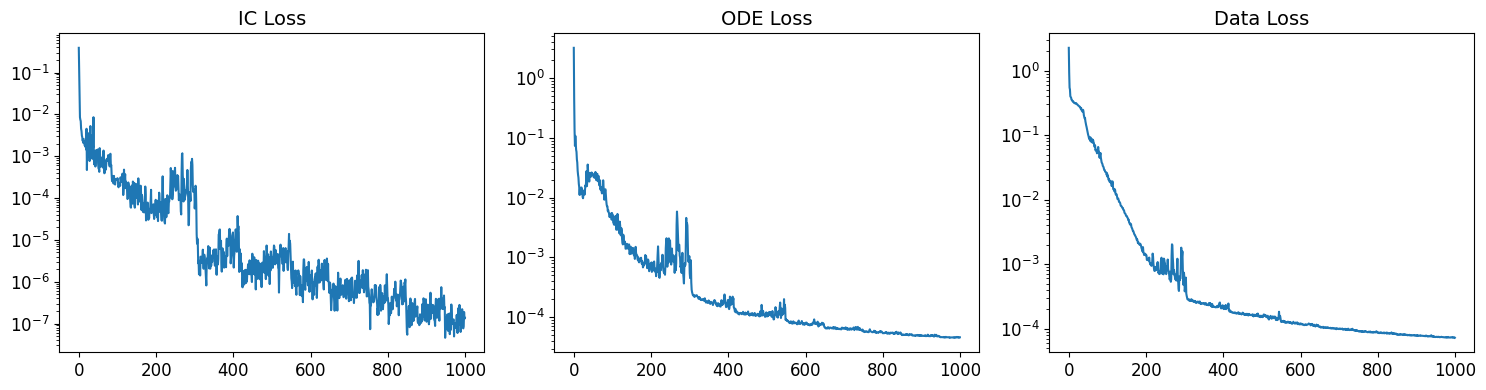

In [14]:
# History
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].plot(range(n_epochs), loss_tracker.loss_history['IC_loss'])
ax[1].plot(range(n_epochs), loss_tracker.loss_history['ODE_loss'])
ax[2].plot(range(n_epochs), loss_tracker.loss_history['Data_loss'])
ax[0].set_title('IC Loss', fontsize=14)
ax[1].set_title('ODE Loss', fontsize=14)
ax[2].set_title('Data Loss', fontsize=14)
for axs in ax:
    axs.set_yscale('log')
    axs.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

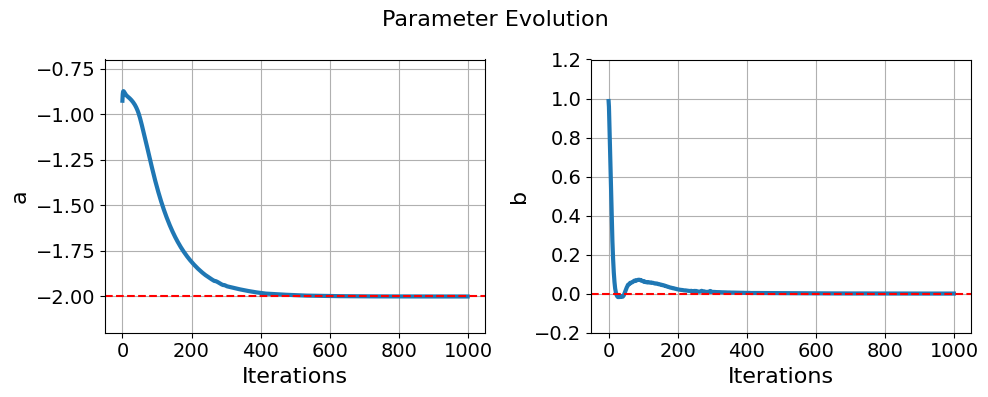

In [15]:
# Parameter history
%matplotlib inline
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(range(n_epochs), a_list, lw=3)
ax[0].set_ylabel('a', fontsize=16)
ax[0].set_xlabel('Iterations', fontsize=16)
ax[0].set_ylim((-2.2, -0.7))
ax[0].axhline(y=-2, color='r', linestyle='--')

ax[1].plot(range(n_epochs), b_list, lw=3)
ax[1].set_ylabel('b', fontsize=16)
ax[1].set_xlabel('Iterations', fontsize=16)
ax[1].set_ylim((-0.2, 1.2))
ax[1].axhline(y=0, color='r', linestyle='--')

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=14)
    axs.grid(True)
fig.suptitle('Parameter Evolution', fontsize=16)
plt.tight_layout()

#### Collect input/output of f-NN 

In [16]:
t = np.linspace(0, 10, 10000).reshape(-1, 1)
u, f = PINN.predict(t, batch_size=12800)

# Configure dataframe
df = pd.DataFrame({
    't': t.flatten(),
    'u1': u[:, 0],
    'u2': u[:, 1],
    'u3': u[:, 2],
    'f1': f[:, 0],
    'f2': f[:, 1]
})
df.to_csv('f_NN_IO.csv', index=False)

1/1 [==============================] - 0s 10ms/step


Text(0.5, 1.0, 'f2')

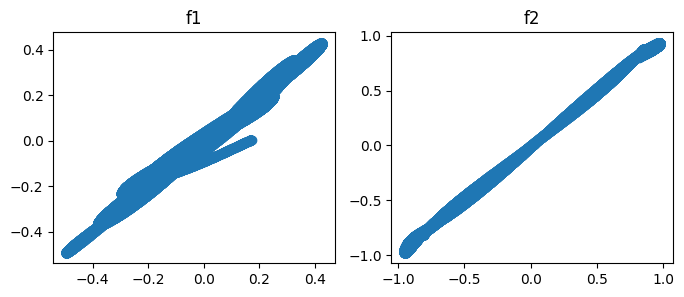

In [17]:
# Sanity check
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].scatter(np.exp(-df.t.values/10)*df.u2.values*df.u3.values, df.f1)
ax[0].set_title('f1')

ax[1].scatter(df.u1.values*df.u3.values, df.f2)
ax[1].set_title('f2')

#### Assess accuracy: u prediction

In [18]:
t = np.linspace(0, 10, 5000).reshape(-1, 1)
pred_u, pred_f = PINN.predict(t, batch_size=12800)

1/1 [==============================] - 0s 13ms/step


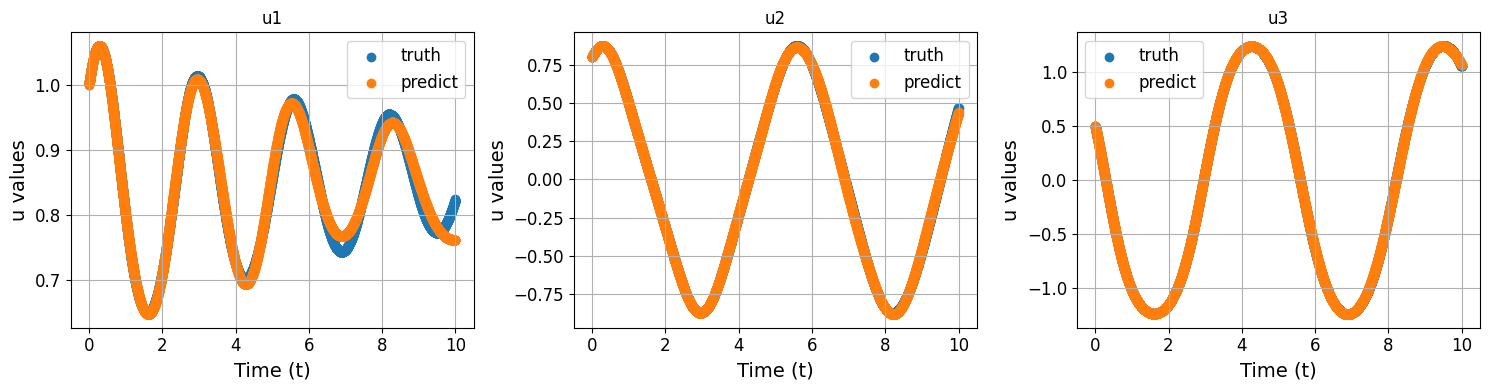

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))

ax[0].scatter(t.flatten(), y_test[:, 0], label='truth')
ax[0].scatter(t.flatten(), pred_u[:, 0], label='predict')
ax[0].set_title('u1')
ax[1].scatter(t.flatten(), y_test[:, 1], label='truth')
ax[1].scatter(t.flatten(), pred_u[:, 1], label='predict')
ax[1].set_title('u2')
ax[2].scatter(t.flatten(), y_test[:, 2], label='truth')
ax[2].scatter(t.flatten(), pred_u[:, 2], label='predict')
ax[2].set_title('u3')

for axs in ax:
    axs.set_xlabel('Time (t)', fontsize=14)
    axs.set_ylabel('u values', fontsize=14)
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.legend(fontsize=12, frameon=True)
    axs.grid(True)

plt.tight_layout()

#### Access accuracy: f prediction

In [13]:
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
with tf.GradientTape() as tape:
    tape.watch(X_test)
    u, f = PINN(X_test)

# Calculate gradients
dudt = tape.batch_jacobian(u, X_test)[:, :, 0]
du1_dt, du2_dt, du3_dt = dudt[:, :1], dudt[:, 1:2], dudt[:, 2:]

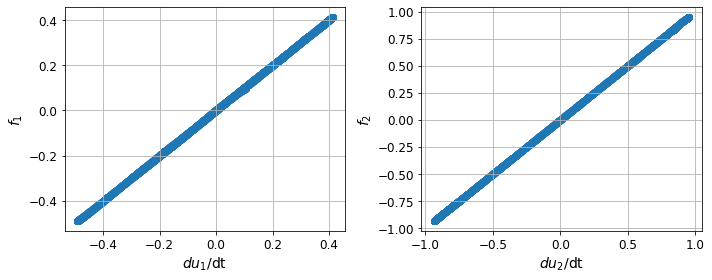

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(du1_dt.numpy().flatten(), f[:, 0].numpy())
ax[0].set_xlabel('$du_1$/dt', fontsize=14)
ax[0].set_ylabel('$f_1$', fontsize=14)
ax[1].scatter(du2_dt.numpy().flatten(), f[:, 1].numpy())
ax[1].set_xlabel('$du_2$/dt', fontsize=14)
ax[1].set_ylabel('$f_2$', fontsize=14)

for axs in ax:
    axs.tick_params(axis='both', which='major', labelsize=12)
    axs.grid(True)

plt.tight_layout()